# Overview

In lieu of documentation, most of the features currently implemented in `brutus` are either shown or discussed here.

# Preamble

As always, let's just set up a nice environment to run these tests.

In [1]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import h5py

import brutus

# plot in-line within the notebook
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Models

`brutus` currently supports two models: MIST and Bayestar. The former are theoretical, provide access to physical parameters, and are supported over a large number of bands. The latter are entirely empirical and only supported over PanSTARRS and 2MASS. Both include Av and Rv dependencies assuming a linear (differential) reddening vector.

We can specify the filters we want to model using collections of pre-defined filtersets included in `filters`.

In [3]:
from brutus import filters

print('All bands:', filters.FILTERS,'\n')

filt = filters.ps[:-2] + filters.tmass
print('Current subset:', filt)

All bands: ['Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', 'PS_w', 'PS_open', 'DECam_u', 'DECam_g', 'DECam_r', 'DECam_i', 'DECam_z', 'DECam_Y', 'Tycho_B', 'Tycho_V', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'UKIDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', 'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 'Hipparcos_Hp', 'Kepler_D51', 'Kepler_Kp', 'TESS'] 

Current subset: ['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']


Models can be read in using the `load_models` function, with some additional functionality that allows you to select specific subsets of the MIST grid (which is quite large).

In [4]:
# import Bayestar models
(models_bs, labels_bs, 
 lmask_bs) = brutus.load_models('../data/DATAFILES/grid_bayestar_v2.h5', 
                                filters=filt)
Nmodels_bs, _, _ = models_bs.shape

print('Number of Bayestar models:', Nmodels_bs)

Reading filter 2MASS_Ks           

Number of Bayestar models: 40896


In [5]:
# import MIST models
(models_mist, labels_mist,
 lmask_mist) = brutus.load_models('../data/DATAFILES/grid_mist_v7.h5', 
                                  filters=filt, include_ms=True, 
                                  include_postms=True, include_binaries=True)
Nmodels_mist, _, _ = models_mist.shape

print('Number of MIST models:', Nmodels_mist)

Reading filter 2MASS_Ks           


Number of MIST models: 1698620


A comparison between the two models is shown below for reference.

In [7]:
# define limits
xlims = np.array([-1., 4.])
ylims = np.array([20., 1.])
xlabel = 'r - z'
ylabel = 'i'
cidx, midx = [1, 3], 2

# get MIST mags/colors
g_mist, r_mist, i_mist, z_mist, y_mist = models_mist[:, :5, 0].T
color_mist = models_mist[:, cidx[0], 0] - models_mist[:, cidx[1], 0]
mag_mist = models_mist[:, midx, 0]
inbounds_mist = ((color_mist > xlims[0]) & (color_mist < xlims[1]) &
                 (mag_mist < ylims[0]) & (mag_mist > ylims[1]))

# get Bayestar mags/colors
color_bs = models_bs[:, cidx[0], 0] - models_bs[:, cidx[1], 0]
mag_bs = models_bs[:, midx, 0]
inbounds_bs = ((color_bs > xlims[0]) & (color_bs < xlims[1]) &
               (mag_bs < ylims[0]) & (mag_bs > ylims[1]))

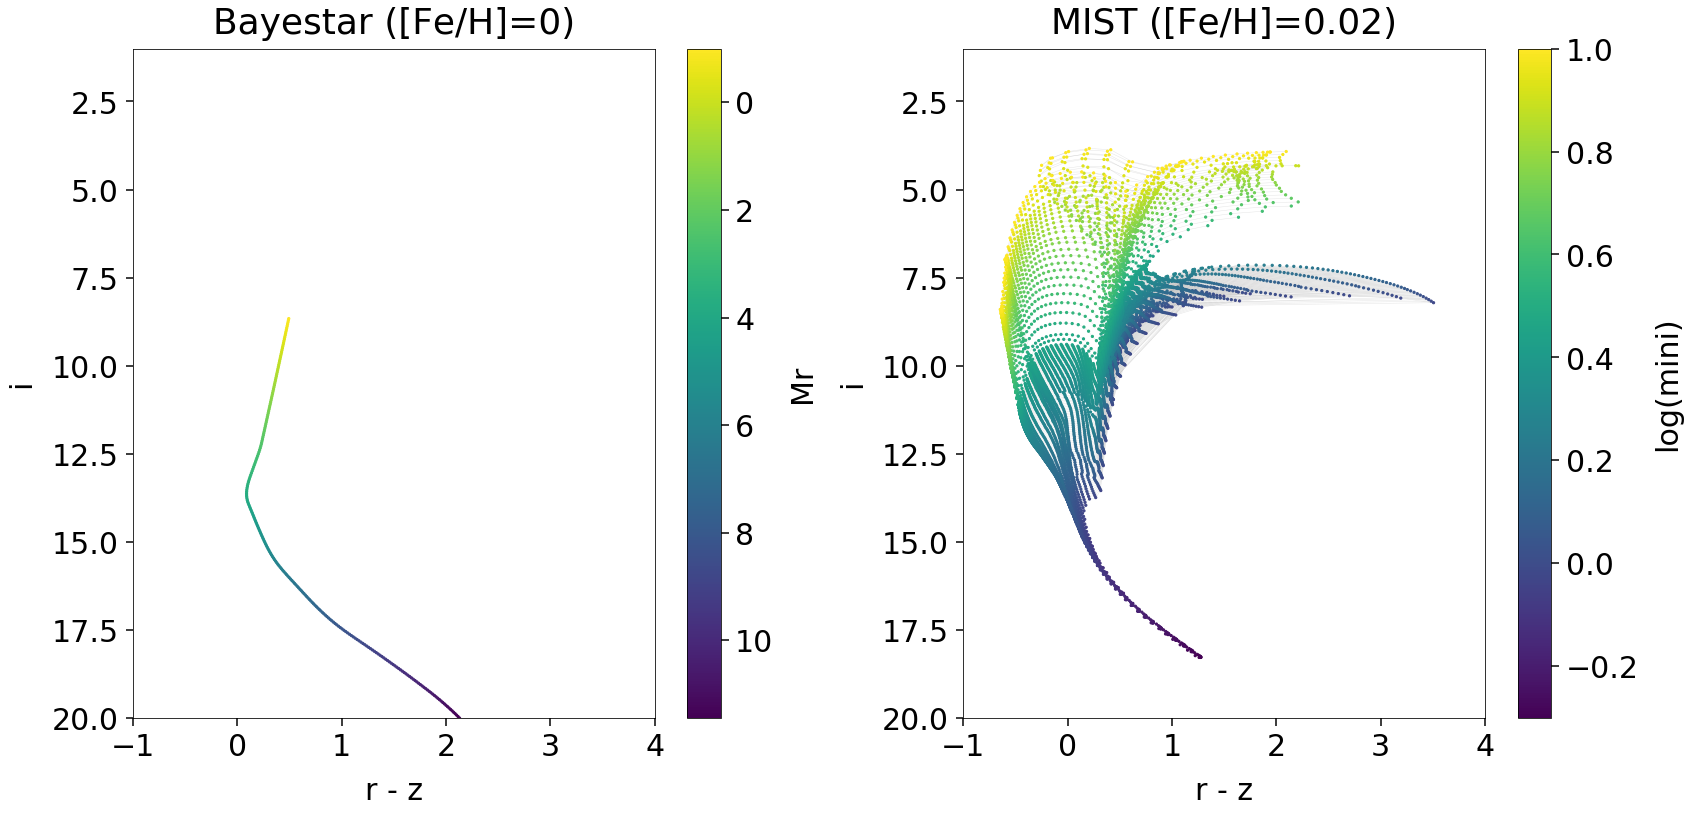

In [8]:
# plot comparison at fixed metallicity
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
sel = (np.isclose(labels_bs['feh'], 0.) & inbounds_bs)
plt.scatter(color_bs[sel], mag_bs[sel], 
            c=labels_bs['Mr'][sel], cmap='viridis_r', s=5)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlims)
plt.ylim(ylims)
cbar = plt.colorbar(label='Mr')
cbar.ax.invert_yaxis()
plt.title('Bayestar ([Fe/H]=0)')
plt.tight_layout()
plt.subplot(1, 2, 2)
sel = (np.isclose(labels_mist['feh'], 0.02) & 
       np.isclose(labels_mist['smf'], 0.) &
       inbounds_mist)
for m in np.unique(labels_mist['mini']):
    s = labels_mist['mini'] == m
    plt.plot(color_mist[sel & s], mag_mist[sel & s], 
             lw=0.5, color='gray', alpha=0.2, zorder=1)
plt.scatter(color_mist[sel], mag_mist[sel], zorder=2,
            c=np.log10(labels_mist['mini'])[sel], cmap='viridis', s=5)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlims)
plt.ylim(ylims)
plt.colorbar(label='log(mini)')
plt.title('MIST ([Fe/H]=0.02)')
plt.tight_layout()

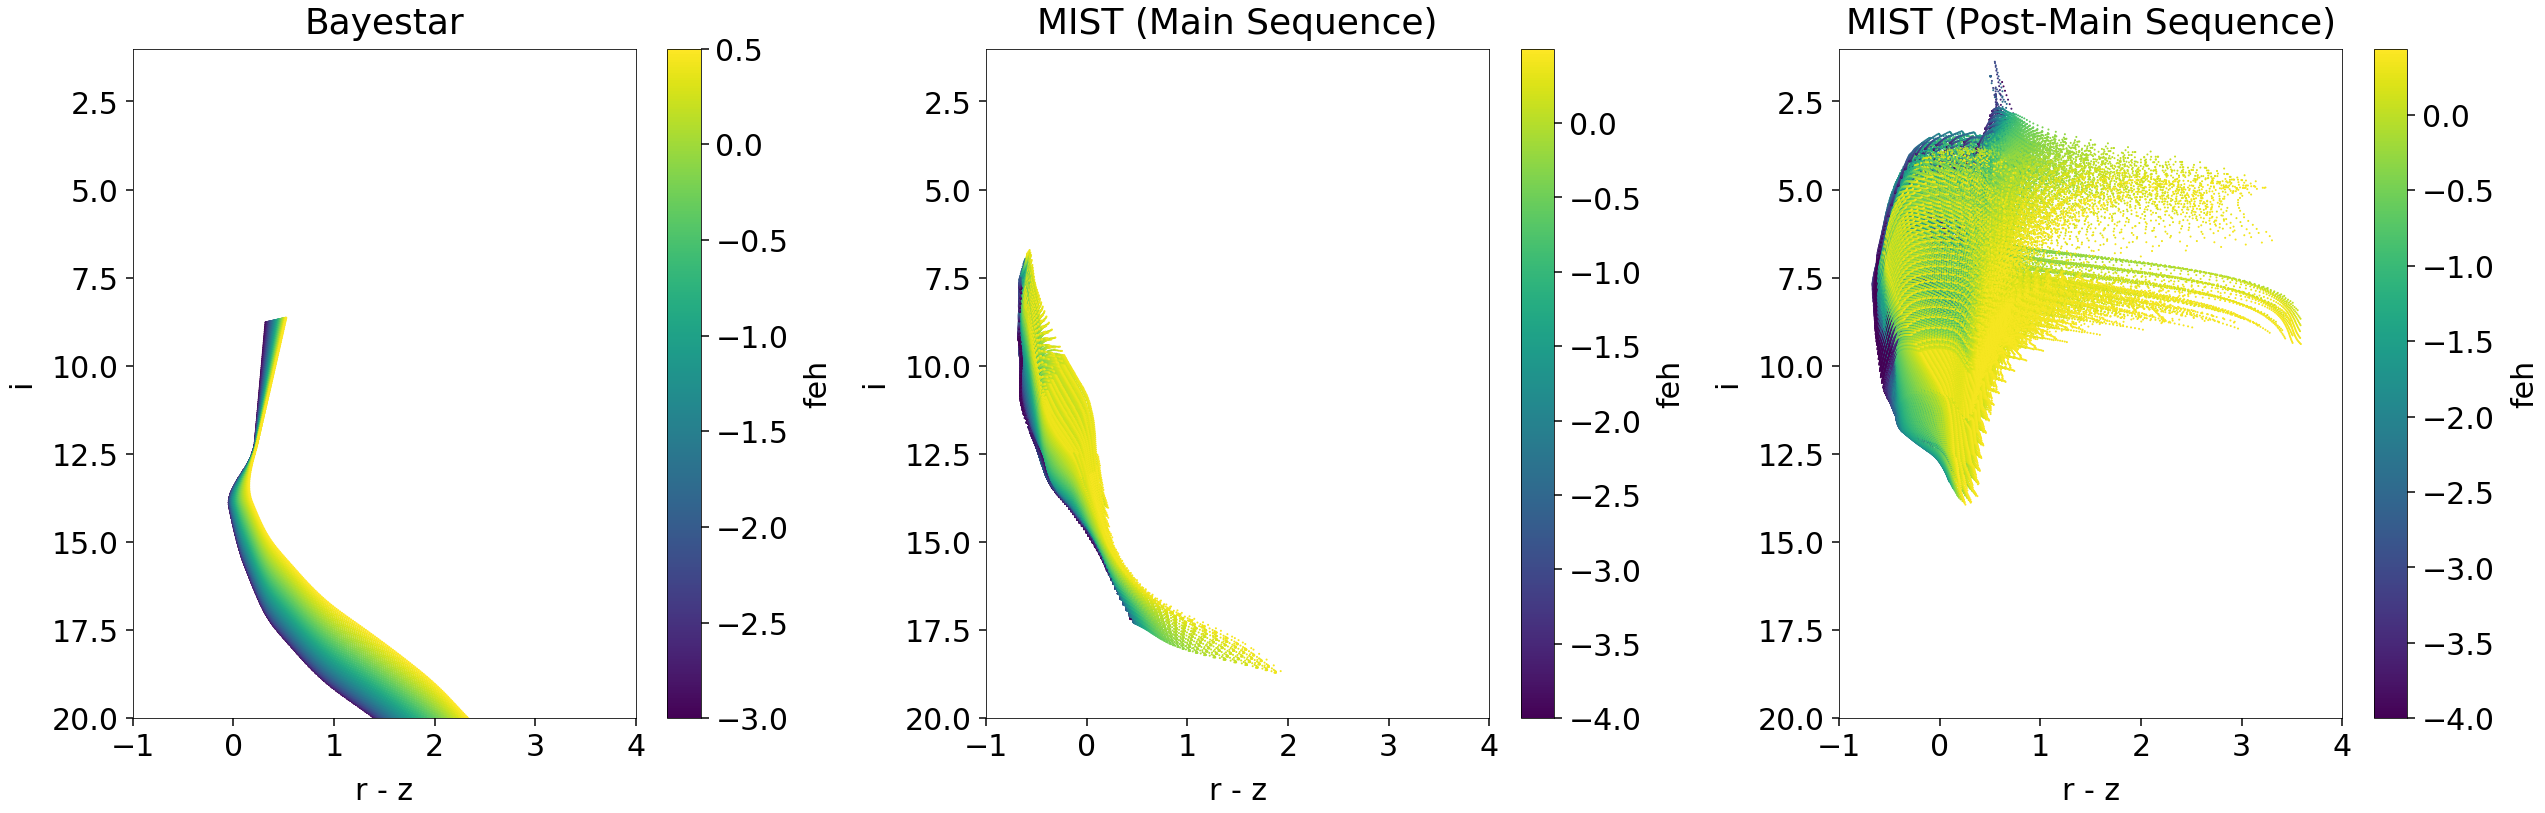

In [14]:
# plot CMDs
plt.figure(figsize=(36, 12))
plt.subplot(1, 3, 1)
plt.scatter(color_bs, mag_bs, c=labels_bs['feh'], s=2)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlims)
plt.ylim(ylims)
plt.colorbar(label='feh')
plt.title('Bayestar')
plt.tight_layout()
plt.subplot(1, 3, 2)
sel = (labels_mist['eep'] <= 454) & (labels_mist['smf'] == 0.)
plt.scatter(color_mist[sel], mag_mist[sel], c=labels_mist['feh'][sel], s=1)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlims)
plt.ylim(ylims)
plt.colorbar(label='feh')
plt.title('MIST (Main Sequence)')
plt.tight_layout()
plt.subplot(1, 3, 3)
sel = (labels_mist['eep'] > 454)
plt.scatter(color_mist[sel], mag_mist[sel], c=labels_mist['feh'][sel], s=1)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlims)
plt.ylim(ylims)
plt.colorbar(label='feh')
plt.title('MIST (Post-Main Sequence)')
plt.tight_layout()

# Zero-Points

Zero-point offsets in a few bands were derived using Gaia data (Speagle et al., in prep.) and can be loaded in using the `load_zeropoints` function.

In [6]:
# load zeropoints
print('Bayestar:')
zp_bs = brutus.load_zeropoints('../data/DATAFILES/offsets_bs_v2.txt', 
                               filters=filt)

Bayestar:


PS_g (-0.39%)
PS_r (-0.98%)
PS_i (-0.54%)
PS_z (-0.044%)
PS_y (0.33%)
2MASS_J (-0.4%)
2MASS_H (0.75%)
2MASS_Ks (0.62%)


In [7]:
# load zeropoints
print('MIST:')
zp_mist = brutus.load_zeropoints('../data/DATAFILES/offsets_mist_v7.txt', 
                                 filters=filt)

MIST:


PS_g (-1.7%)
PS_r (-5.8%)
PS_i (-4.5%)
PS_z (-5.5%)
PS_y (-3.8%)
2MASS_J (-1.7%)
2MASS_H (3.6%)
2MASS_Ks (2.2%)


# SEDs

SEDs from MIST can be generated "on the fly" using the `seds` module. There are two built-in approaches: generating SEDs along mass tracks and generating SEDs along isochrones. The physical parameters are interpolated along the mass tracks, and the relevant photometry is then generated using artificial neural networks trained on bolometric correction tables. An empirical correction file calibrated on a few clusters is also included, which generally improves the performance of the models above 0.5 solar masses.

In [11]:
from brutus import seds

# SEDs along mass tracks
sedmaker = seds.SEDmaker(filters=filt, nnfile='../data/DATAFILES/nnMIST_BC.h5',
                         mistfile='../data/DATAFILES/MIST_1.2_EEPtrk.h5',
                         corrfile='../data/DATAFILES/corr_mist_v1.txt')

# SEDS along isochrones
isochrone = seds.Isochrone(filters=filt, nnfile='../data/DATAFILES/nnMIST_BC.h5',
                           mistfile='../data/DATAFILES/MIST_1.2_iso.h5',
                           corrfile='../data/DATAFILES/corr_mist_v1.txt')

Filters: ['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']
Constructing MIST library...done!
Computing age weights for track (mini, feh) = (300.0, 0.5)        
Initializing FastNN predictor...done!
Initializing FastNN predictor...done!


Both objects support Av and Rv variation as well as secondary mass fractions for modeling unresolved binaries. Some usage examples are shown below.

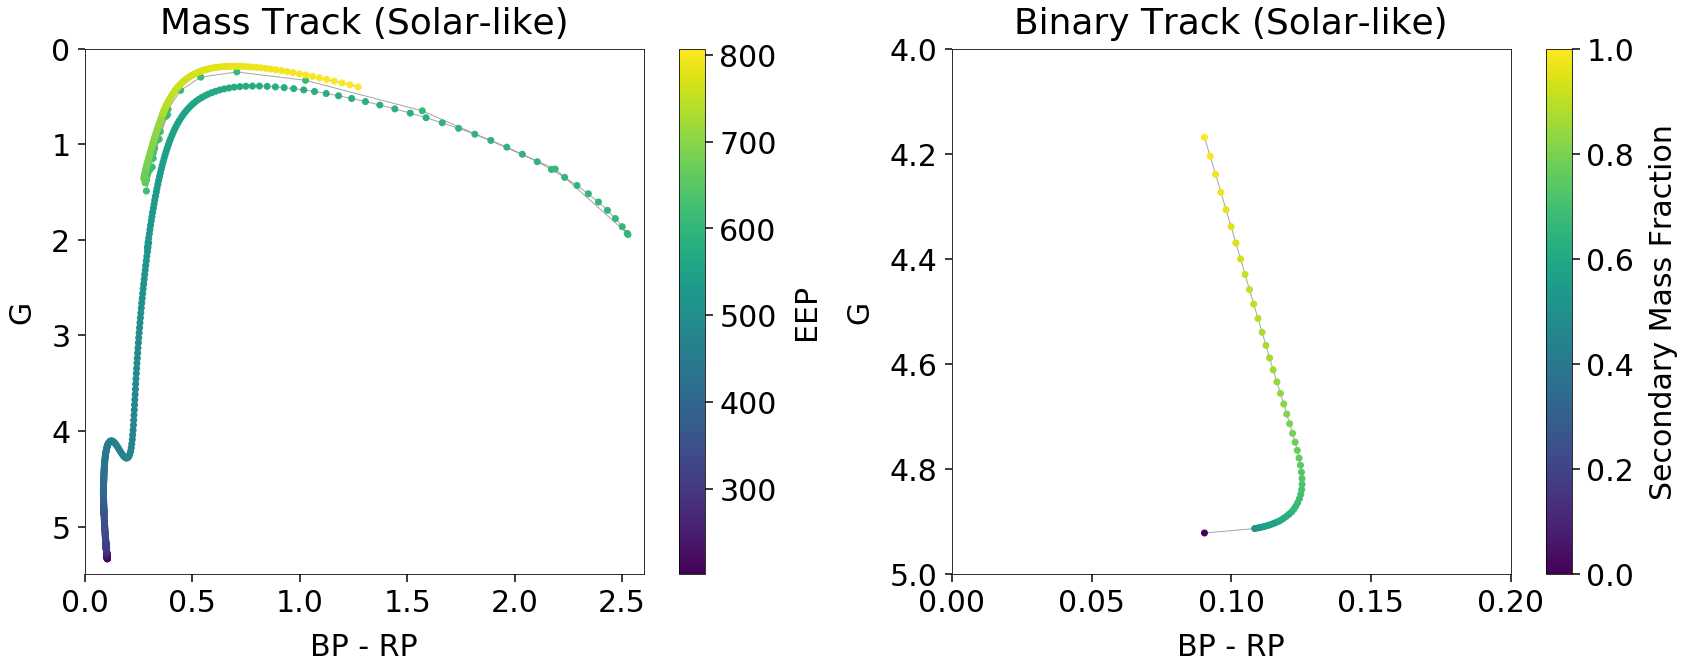

In [116]:
plt.figure(figsize=(24, 10))

# get mass track for sun-like star
eepgrid = np.arange(202, 808, 1)
G, BP, RP = np.zeros((3, len(eepgrid)))
for i, eep in enumerate(eepgrid):
    mags, params_prim, params_sec = sedmaker.get_sed(mini=1., feh=0., eep=eep, 
                                                     av=0., rv=3.3, smf=0., 
                                                     dist=10.)
    G[i], BP[i], RP[i] = mags[:3]

# plot results
plt.subplot(1, 2, 1)
plt.scatter(BP - RP, G, c=eepgrid, zorder=2)
plt.plot(BP - RP, G, color='gray', lw=1, alpha=0.7, zorder=1)
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.xlim([0., 2.6])
plt.ylim([5.5, 0.])
plt.colorbar(label='EEP')
plt.title('Mass Track (Solar-like)')
plt.tight_layout()

# show binary track
smfgrid = np.linspace(0., 1., 100)
G, BP, RP = np.zeros((3, len(smfgrid)))
for i, smf in enumerate(smfgrid):
    mags, params_prim, params_sec = sedmaker.get_sed(mini=1., feh=0., eep=350., 
                                                     av=0., rv=3.3, smf=smf, 
                                                     dist=10.)
    G[i], BP[i], RP[i] = mags[:3]
    
# plot results
plt.subplot(1, 2, 2)
plt.scatter(BP - RP, G, c=smfgrid, zorder=2)
plt.plot((BP - RP)[np.isfinite(G)], G[np.isfinite(G)], 
         color='gray', lw=1, alpha=0.7, zorder=1)
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.xlim([0., 0.2])
plt.ylim([5., 4.])
plt.colorbar(label='Secondary Mass Fraction')
plt.title('Binary Track (Solar-like)')
plt.tight_layout()

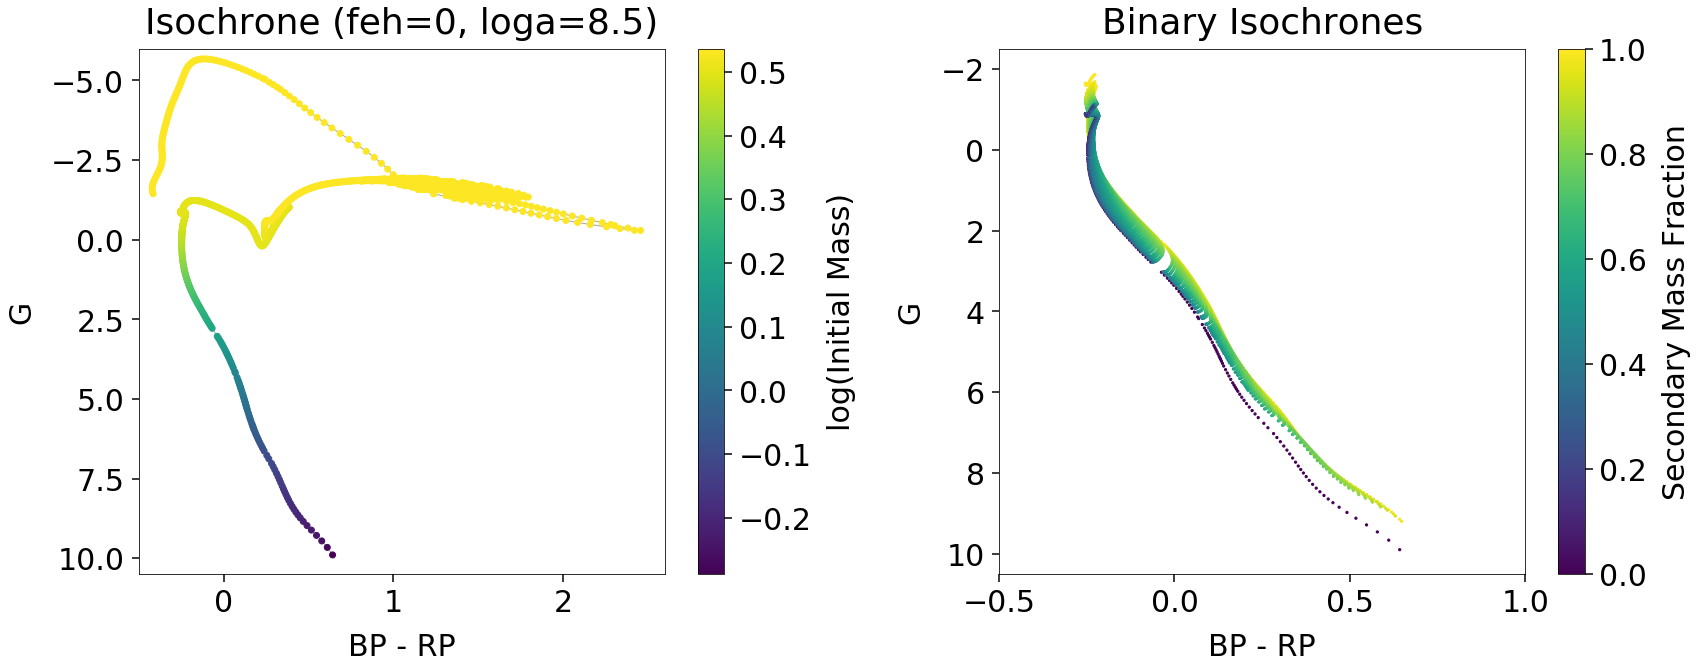

In [178]:
# generate isochrones
smfgrid = np.linspace(0., 1., 51)
mags_arr = []
eeps = []
for smf in smfgrid:
    mags, params_prim, params_sec = isochrone.get_seds(feh=0., loga=8.5, 
                                                       av=0., rv=3.3,
                                                       smf=smf, dist=10.)
    mags_arr.append(mags)
    eeps.append(isochrone.eep_u)
mags_arr, eeps = np.array(mags_arr), np.array(eeps)
G, BP, RP = mags_arr[:, :, :3].T

# plot results
plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
plt.scatter(BP[:, 0] - RP[:, 0], G[:, 0], 
            c=np.log10(params_prim['mini']), zorder=2)
plt.plot(BP[:, 0] - RP[:, 0], G[:, 0], color='gray', lw=1, alpha=0.7, zorder=1)
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.xlim([-0.5, 2.6])
plt.ylim([10.5, -6])
plt.colorbar(label='log(Initial Mass)')
plt.title('Isochrone (feh=0, loga=8.5)')
plt.subplot(1, 2, 2)
plt.scatter((BP - RP)[eeps.T < 454].flatten(), G[eeps.T < 454].flatten(), 
            c=np.tile(smfgrid, len(isochrone.eep_u))[eeps.T.flatten() < 454],
            s=5)  # only include EEP < 454 to avoid overplotting evolved objects
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.xlim([-0.5, 1.])
plt.ylim([10.5, -2.5])
plt.colorbar(label='Secondary Mass Fraction')
plt.title('Binary Isochrones')
plt.tight_layout()

# Priors

`brutus` is primarily designed to fit individual stars (or unresolved binaries) along the line of sight. This involves a decent amount of priors both on stellar properties (initial mass, etc.) and on galactic properties (stellar number densities, dust distributions, etc.). These are implemented in the `pdf` module in a flexible way so that users can (theoretically) change them as appropriate.

## Galactic Priors

In terms of stellar galactic priors, `brutus` invokes a physical 3-component model based on the thin disk, thick disk, and halo from Green et al. (2014). This forms a joint prior on distance and metallicity.

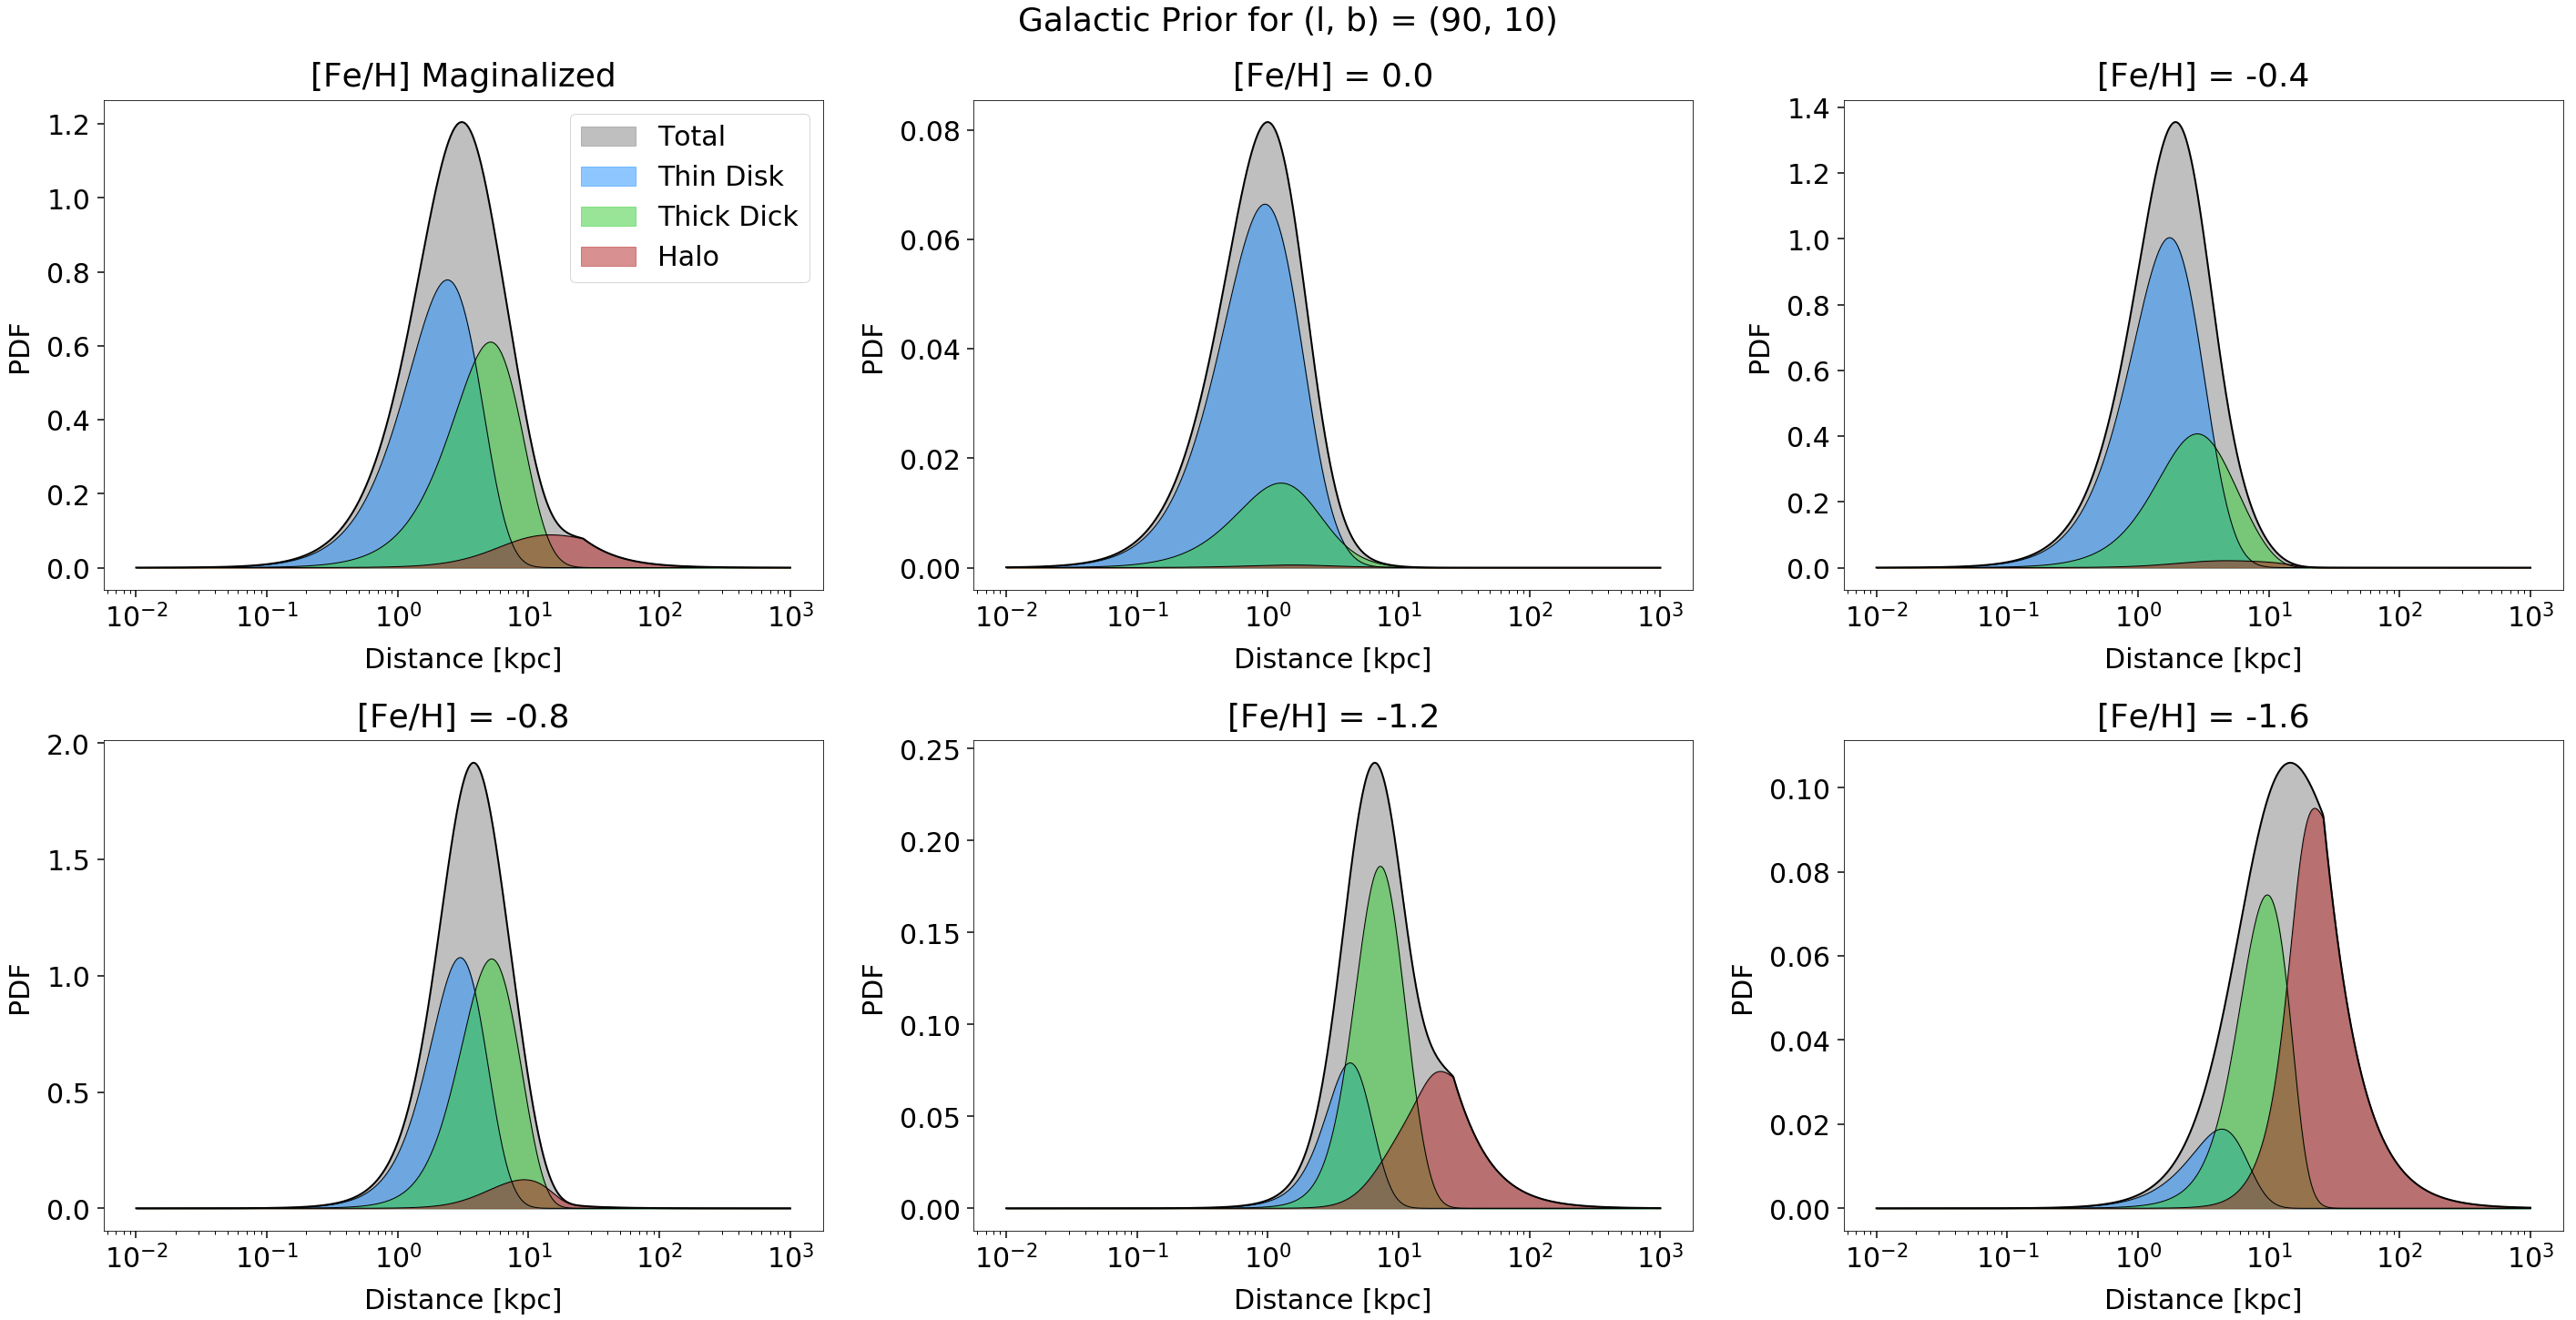

In [128]:
from brutus import pdf

dists = np.logspace(-2, 3, 1000)
coord = np.array([90, 10])  # (l, b)
fehs = [np.nan, 0., -0.4, -0.8, -1.2, -1.6]

plt.figure(figsize=(40, 20))
for i, feh in enumerate(fehs):
    if np.isnan(feh):
        labels = None
        lnp, (lnp_thin, lnp_thick, lnp_halo) = pdf.gal_lnprior(dists, coord,
                                                               return_components=True)
    else:
        labels = {'feh': np.full_like(dists, feh)}
        lnp, (lnp_thin, lnp_thick, lnp_halo,
              lnpf_thin, lnpf_thick, lnpf_halo) = pdf.gal_lnprior(dists, coord, labels=labels,
                                                                  return_components=True)
    # Compute component probabilities.
    ptot = np.exp(lnp)
    # number density component
    pthin, pthick, phalo = np.exp(lnp_thin), np.exp(lnp_thick), np.exp(lnp_halo)
    if np.isfinite(feh):
        # metallicity component
        pfthin, pfthick, pfhalo = np.exp(lnpf_thin), np.exp(lnpf_thick), np.exp(lnpf_halo)
        # multiply by metallicity-based distribution
        pf = pfthin + pfthick + pfhalo
        pthin *= pf
        pthick *= pf
        phalo *= pf

    # plot results
    plt.subplot(2, 3, i+1)
    plt.fill_between(dists, ptot, color='gray', alpha=0.5, 
                     label='Total')
    plt.semilogx(dists, ptot, color='black', lw=2)
    plt.fill_between(dists, pthin, color='dodgerblue', alpha=0.5, 
                     label='Thin Disk')
    plt.semilogx(dists, pthin, color='black', lw=1)
    plt.fill_between(dists, pthick, color='limegreen', alpha=0.5,
                     label='Thick Dick')
    plt.semilogx(dists, pthick, color='black', lw=1)
    plt.fill_between(dists, phalo, color='firebrick', alpha=0.5,
                     label='Halo')
    plt.semilogx(dists, phalo, color='black', lw=1)
    plt.xlabel('Distance [kpc]')
    plt.ylabel('PDF')
    if np.isnan(feh):
        plt.title('[Fe/H] Maginalized')
        plt.legend()
    else:
        plt.title('[Fe/H] = {}'.format(feh))
plt.suptitle('Galactic Prior for (l, b) = ({}, {})'.format(coord[0], coord[1]), y=1.02)
plt.tight_layout()

For dust, `brutus` by default assumes a model based on the 3-D dust map derived from Green et al. (2018). Note that the map itself can be accessed using the `Bayestar` object in `utils`.

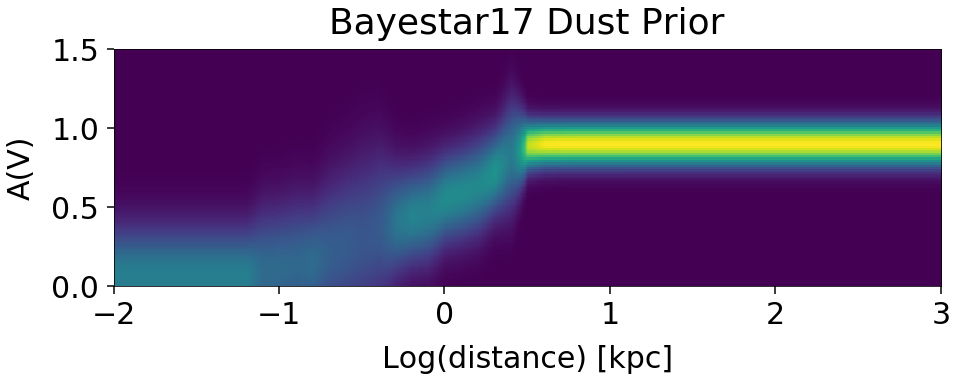

In [147]:
avgrid = np.linspace(0, 1.5, 100)
lnpgrid = np.zeros((len(avgrid), len(dists)))

for i, av in enumerate(avgrid):
    avs = np.full_like(dists, av)
    # sample dust prior
    lnpgrid[i] = pdf.dust_lnprior(dists, coord, avs, dustfile='../data/DATAFILES/bayestar2017_v1.h5')

# plot results
plt.figure(figsize=(14, 6))
plt.imshow(np.exp(lnpgrid), origin='lower', 
           extent=[np.log10(dists.min()), np.log10(dists.max()), 
                   avgrid.min(), avgrid.max()], 
           aspect='auto')
plt.xlabel('Log(distance) [kpc]')
plt.ylabel('A(V)')
plt.title('Bayestar17 Dust Prior')
plt.tight_layout()

## Stellar Priors

The current per-object stellar priors are relatively weak. By default, the only prior assumed by the code is a prior over "mass". For the MIST models this is implemented directly as a prior over the IMF. Since the Bayestar models do not have access to this information, a prior is instead placed on the observed luminosity function (specifically the absolute magnitude in the PanSTARRS r-band).

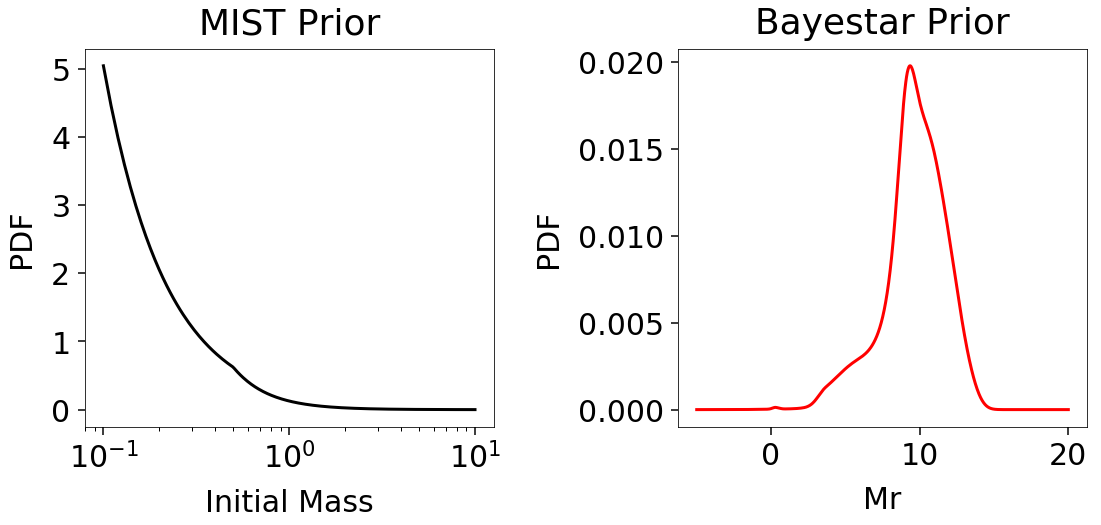

In [161]:
# IMF prior (default Kroupa)
mini = np.linspace(0.1, 10, 1000)
lnp_imf = pdf.imf_lnprior(mini)

# MR prior
mr = np.linspace(-5., 20., 1000)
lnp_mr = pdf.ps1_MrLF_lnprior(mr)

# plot results
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.semilogx(mini, np.exp(lnp_imf), lw=3, color='black')
plt.xlabel('Initial Mass')
plt.ylabel('PDF')
plt.title('MIST Prior')
plt.subplot(1, 2, 2)
plt.plot(mr, np.exp(lnp_mr), lw=3, color='red')
plt.xlabel('Mr')
plt.ylabel('PDF')
plt.title('Bayestar Prior')
plt.tight_layout()

For binaries, MIST assumes that both components are drawn independently from the IMF, giving a straightforward 2-D prior on primary and secondary mass.

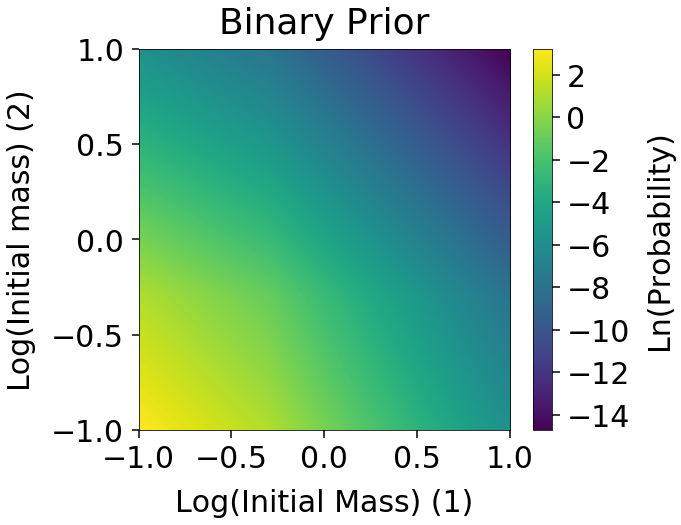

In [176]:
# IMF prior (default Kroupa)
mini = np.logspace(-1, 1, 500)
lnp_imf = np.zeros((len(mini), len(mini)))
for i, m2 in enumerate(mini):
    mini2 = np.full_like(mini, m2)
    lnp_imf[i] = pdf.imf_lnprior(mini, mgrid2=mini2)
    
# plot results
plt.figure(figsize=(10, 8))
plt.imshow(lnp_imf, origin='lower', 
           extent=np.log10(np.array([mini.min(), mini.max(), 
                                     mini.min(), mini.max()])), 
           aspect='auto')
plt.xlabel('Log(Initial Mass) (1)')
plt.ylabel('Log(Initial mass) (2)')
plt.title('Binary Prior')
plt.colorbar(label='Ln(Probability)')
plt.tight_layout()

# Deriving Stellar Posteriors

The main way that `brutus` is able to derive stellar posteriors to individual stars is through the `BruteForce` object in the `fitting` module. This uses a combination of brute-force inference and optimization techniques over the provided stellar grid to derive posterior probabilities for each grid point. Results are then stored as a set of samples drawn from the final set of grid points proportional to their posterior probabilities.

Initializing the object is straightforward.

In [8]:
# load in fitter
from brutus import fitting
BF_bs = fitting.BruteForce(models_bs, labels_bs, lmask_bs)
BF_mist = fitting.BruteForce(models_mist, labels_mist, lmask_mist)

For this demo, we'll fit a handful of objects from Orion (courtesy of Catherine Zucker). Note that all fluxes/errors **must be** in mag-native units (i.e. $10^{-0.4 m}$) and all parallaxes **must be** in mas.

In [9]:
# load in data
from brutus.utils import inv_magnitude
filename = 'Orion_l204.7_b-19.2'
f = h5py.File(filename+'.h5')
fpix = f['photometry']['pixel 0-0']
mag, magerr = fpix['mag'], fpix['err']
mask = np.isfinite(magerr)  # create boolean band mask
phot, err = inv_magnitude(mag, magerr)  # convert to flux
objid = fpix['obj_id']
parallax, parallax_err = fpix['parallax'] * 1e3, fpix['parallax_error'] * 1e3  # convert to mas
psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = np.c_[fpix['l'], fpix['b']]

Nobjs = len(phot)
print(Nobjs)

1642


/home/joshspeagle/anaconda3/lib/python3.6/site-packages/brutus-0.6.9-py3.6.egg/brutus/utils.py:493: RuntimeWarning: overflow encountered in power
  phot = 10**(-0.4 * mag) * zeropoints


There are a large number of "bells and whistles" involved in the fitting. These are described extensively in the doc strings, with a few highlighted below for reference.

In [10]:
# fit a set of hypothetical objects
BF_bs.fit(phot[:10], err[:10], mask[:10], 
          objid[:10],  # additional information to be written out
          filename+'_bs',  # filename (.h5 to be added)
          data_coords=coords[:10],  # array of (l, b) coordinates used for distance prior
          parallax=parallax[:10], parallax_err=parallax_err[:10],  # parallax measurements
          phot_offsets=zp_bs,  # photometric offsets read in earlier
          dustfile='../data/DATAFILES/bayestar2017_v1.h5',  # 3-D dustmap prior
          Ndraws=2000,  # number of samples to save
          Nmc_prior=100,  # number of Monte Carlo draws used to integrate priors
          logl_dim_prior=True,  # use chi2 distribution instead of Gaussian
          save_dar_draws=True,  # save (dist, Av, Rv) samples
          running_io=True,  # write out objects as soon as they finish
          verbose=True)  # print progress

Fitting object 10/10 (mean time: 1.216 s/obj, est. time remaining:      0.000 s)


In [22]:
# MIST
BF_mist.fit(phot[:10], err[:10], mask[:10], objid[:10], 
            filename+'_mist',
            parallax=parallax[:10], parallax_err=parallax_err[:10], 
            data_coords=coords[:10], 
            dustfile='../data/DATAFILES/bayestar2017_v1.h5',
            phot_offsets=zp_mist,
            running_io=False)

Fitting object 10/10 (mean time: 11.070 s/obj, est. time remaining:      0.000 s)


Since results are stored in h5 format, they're pretty easy to read back in.

In [11]:
# load Bayestar results
f = h5py.File(filename+'_bs'+'.h5')
idxs_bs = f['idxs'][:]  # model indices
chi2_bs = f['best_chi2'][:]  # best-fit chi2
nbands_bs = f['Nbands'][:]  # number of bands in fit
dists_bs = f['dists'][:]  # distance samples
reds_bs = f['reds'][:]  # A(V) samples
dreds_bs = f['dreds'][:]  # R(V) samples

In [23]:
# load MIST results
f = h5py.File(filename+'_mist'+'.h5')
idxs_mist = f['idxs'][:]
chi2_mist = f['best_chi2'][:]
nbands_mist = f['Nbands'][:]
dists_mist = f['dists'][:]
reds_mist = f['reds'][:]
dreds_mist = f['dreds'][:]

# Visualizing Results

`brutus` contains a number of utilities for visualizing results in the `plotting` module. We illustrate a few below.

In [50]:
from brutus import plotting as bplot

# pick an object
i = 3

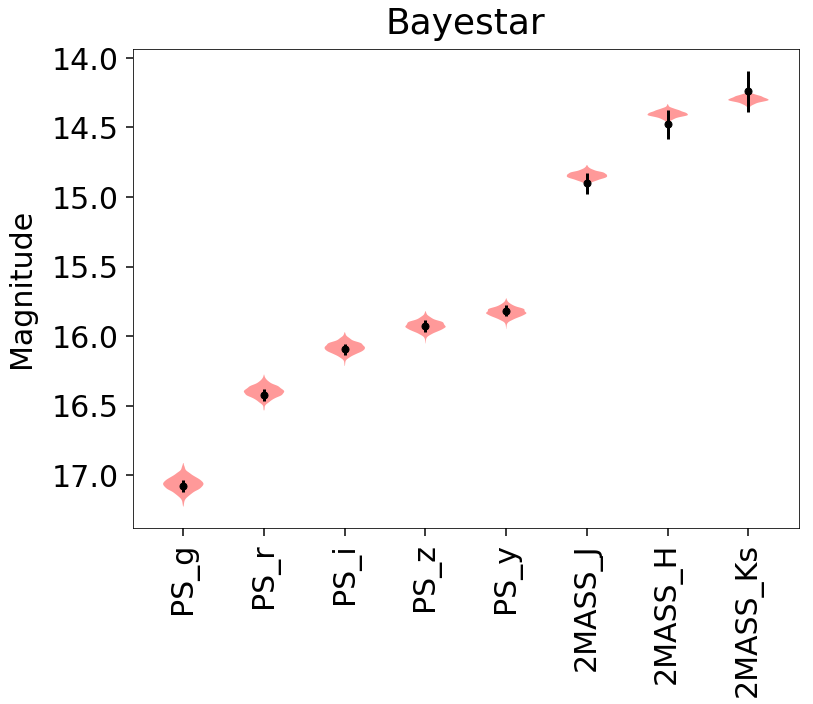

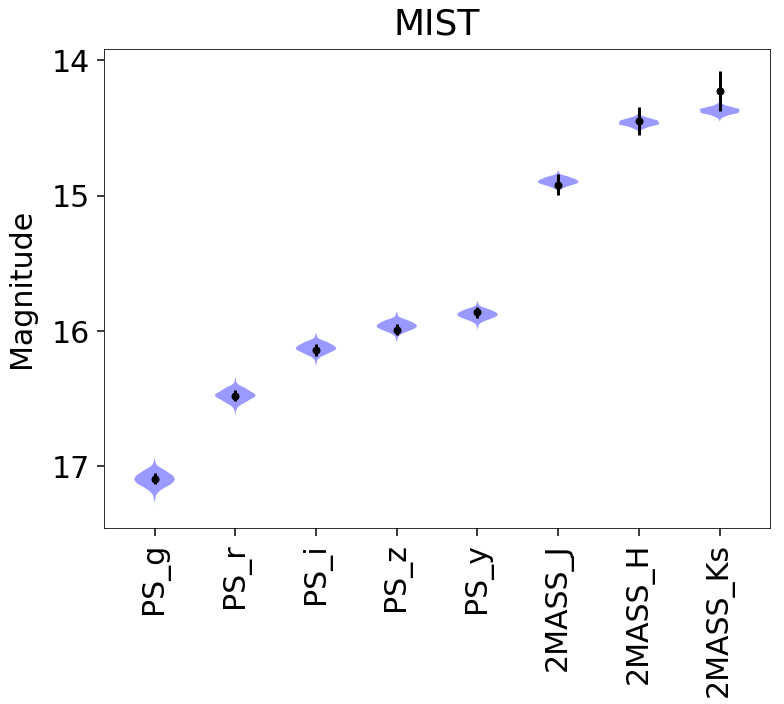

In [51]:
# plot SEDs (posterior predictive)

# Bayestar
fig, ax, parts = bplot.posterior_predictive(models_bs, idxs_bs[i], 
                                            reds_bs[i], dreds_bs[i], dists_bs[i], 
                                            data=phot[i], data_err=err[i], 
                                            data_mask=mask[i],
                                            offset=zp_bs, psig=2.,
                                            labels=filt, vcolor='red', pcolor='black')
plt.title('Bayestar')

# MIST
fig, ax, parts = bplot.posterior_predictive(models_mist, idxs_mist[i], 
                                            reds_mist[i], dreds_mist[i], dists_mist[i], 
                                            data=phot[i], data_err=err[i], 
                                            data_mask=mask[i],
                                            offset=zp_mist, psig=2.,
                                            labels=filt, vcolor='blue', pcolor='black')
plt.title('MIST');

Best-fit chi2 (Bayestar): 3.709531
Best-fit chi2 (MIST): 4.3647327


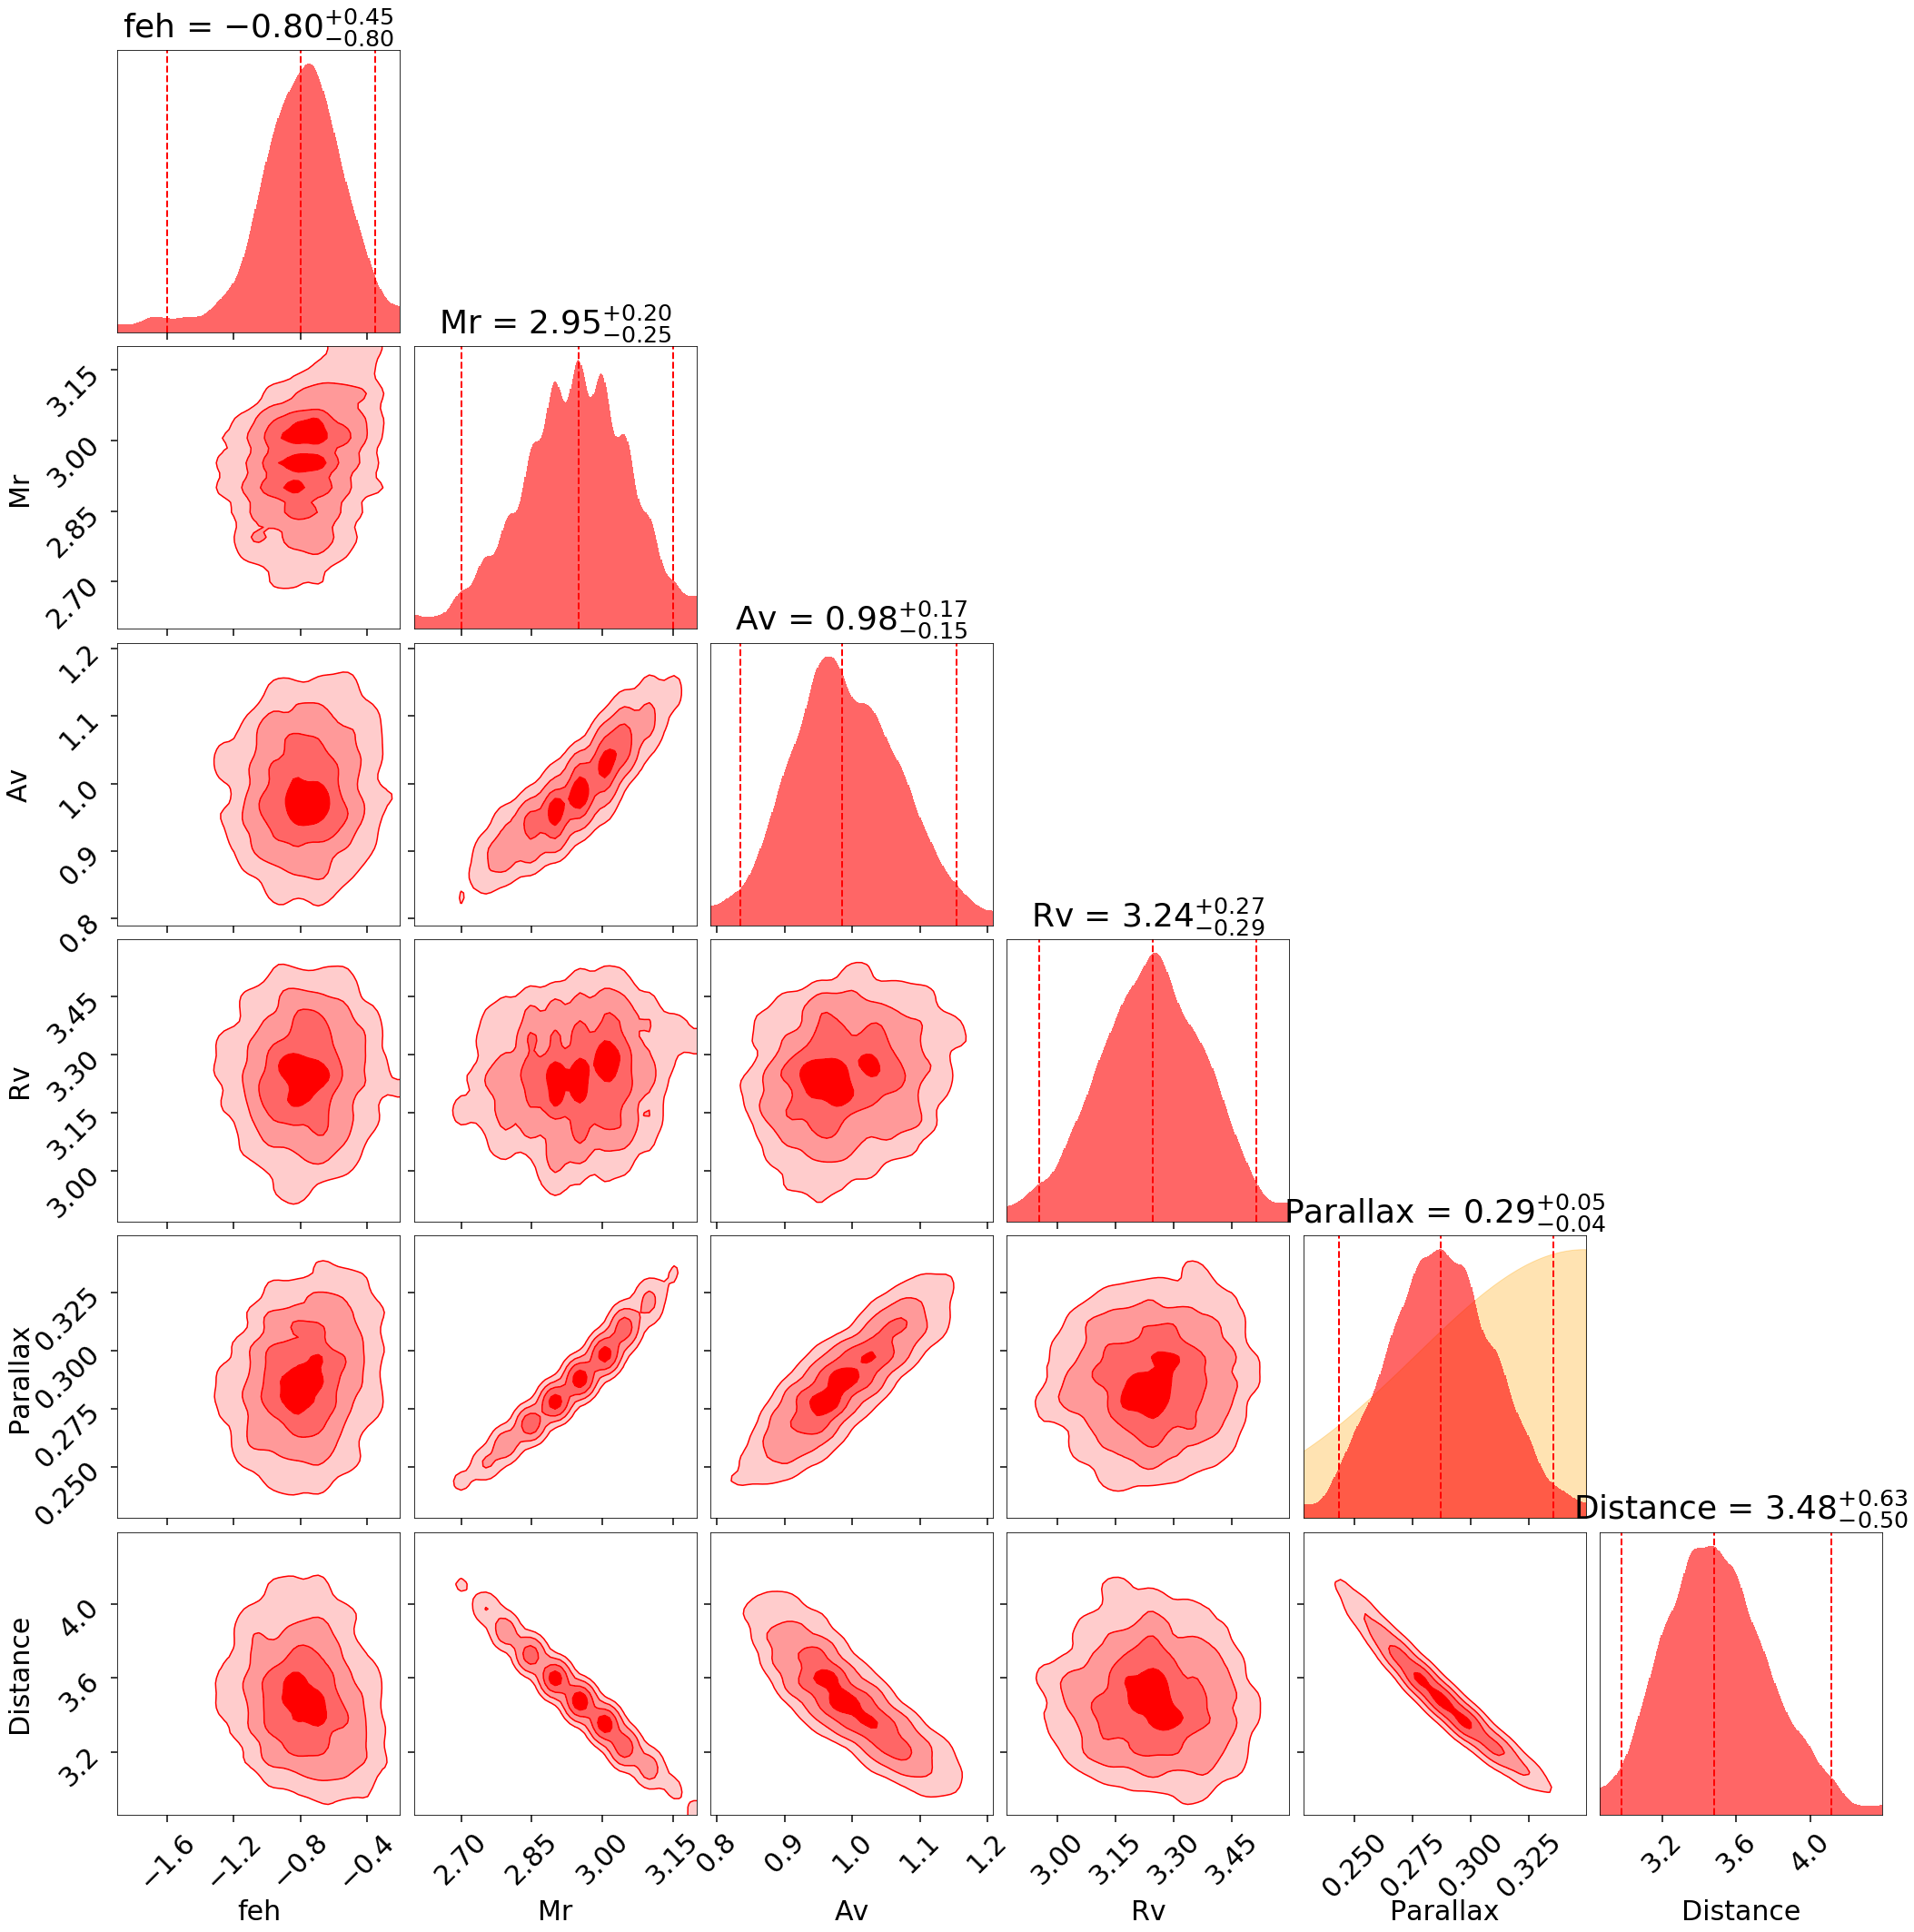

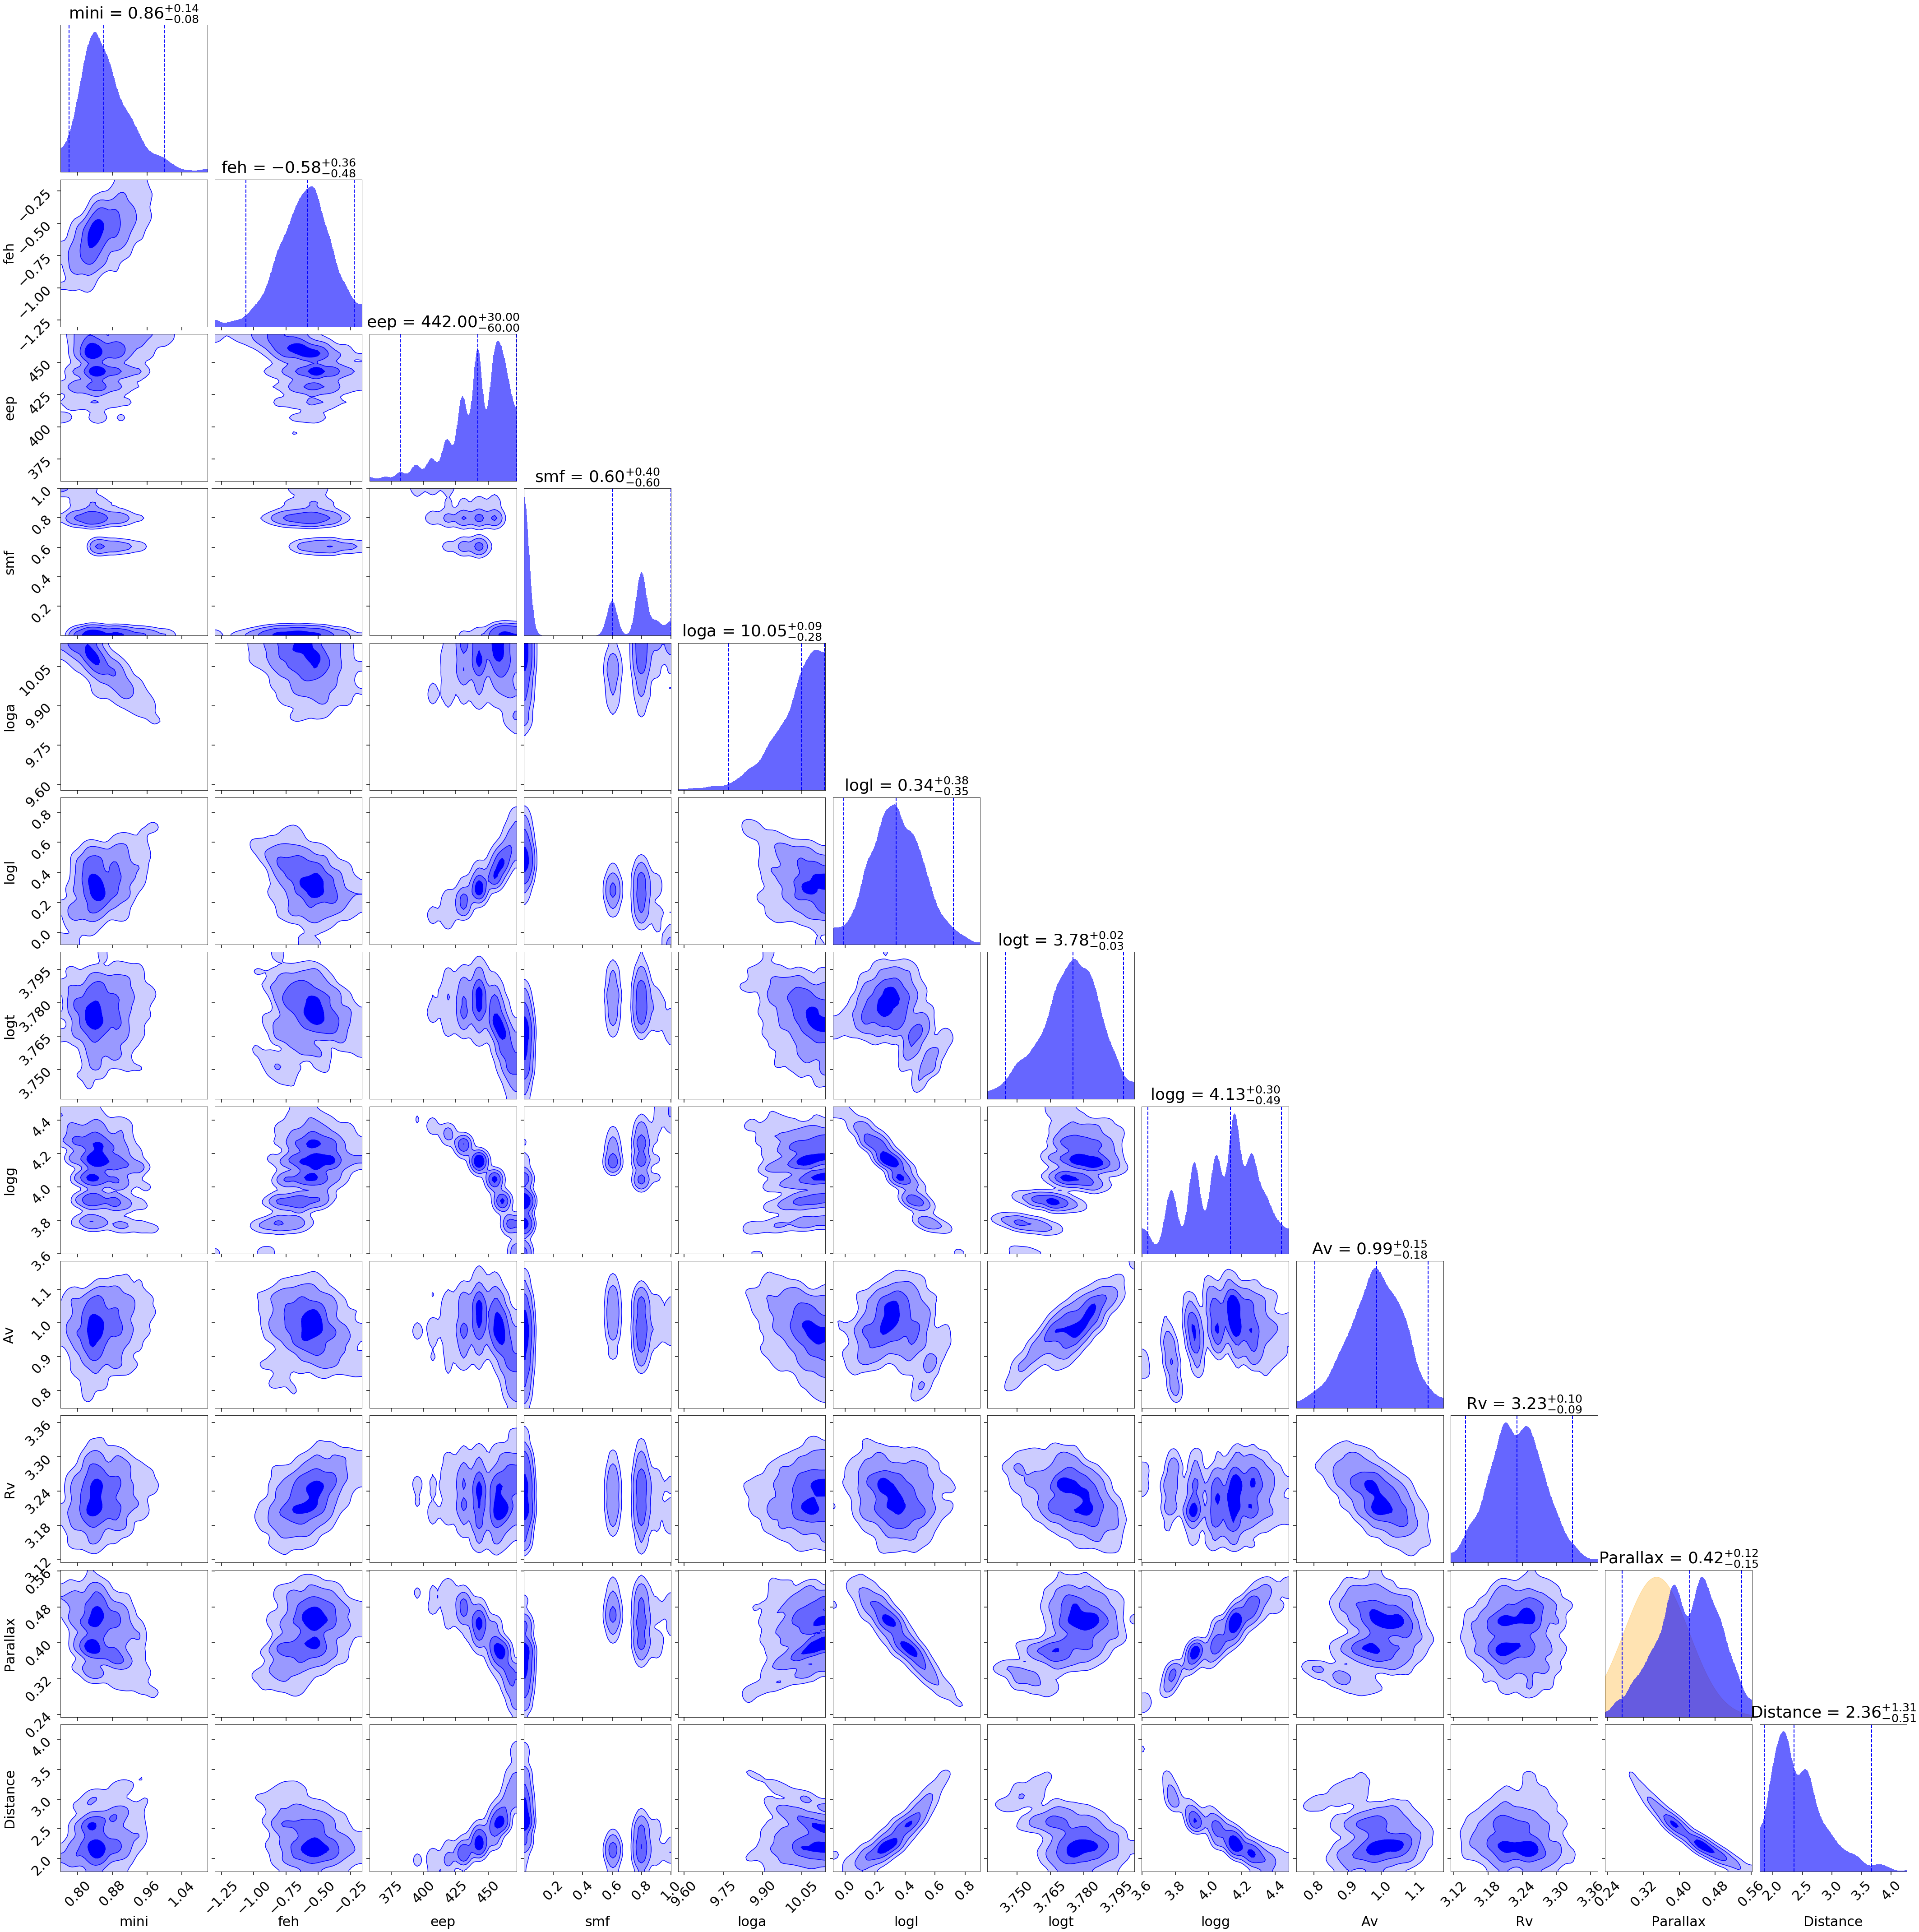

In [52]:
# plot corner distributions

# Bayestar
print('Best-fit chi2 (Bayestar):', chi2_bs[i])
fig, axes = bplot.cornerplot(idxs_bs[i], (dists_bs[i], reds_bs[i], dreds_bs[i]),
                             labels_bs,
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, color='red', pcolor='orange',
                             fig=plt.subplots(6, 6, figsize=(30, 30)))

# MIST
print('Best-fit chi2 (MIST):', chi2_mist[i])
fig, axes = bplot.cornerplot(idxs_mist[i], (dists_mist[i], reds_mist[i], dreds_mist[i]),
                             labels_mist,
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, color='blue', pcolor='orange',
                             fig=plt.subplots(12, 12, figsize=(60, 60)))

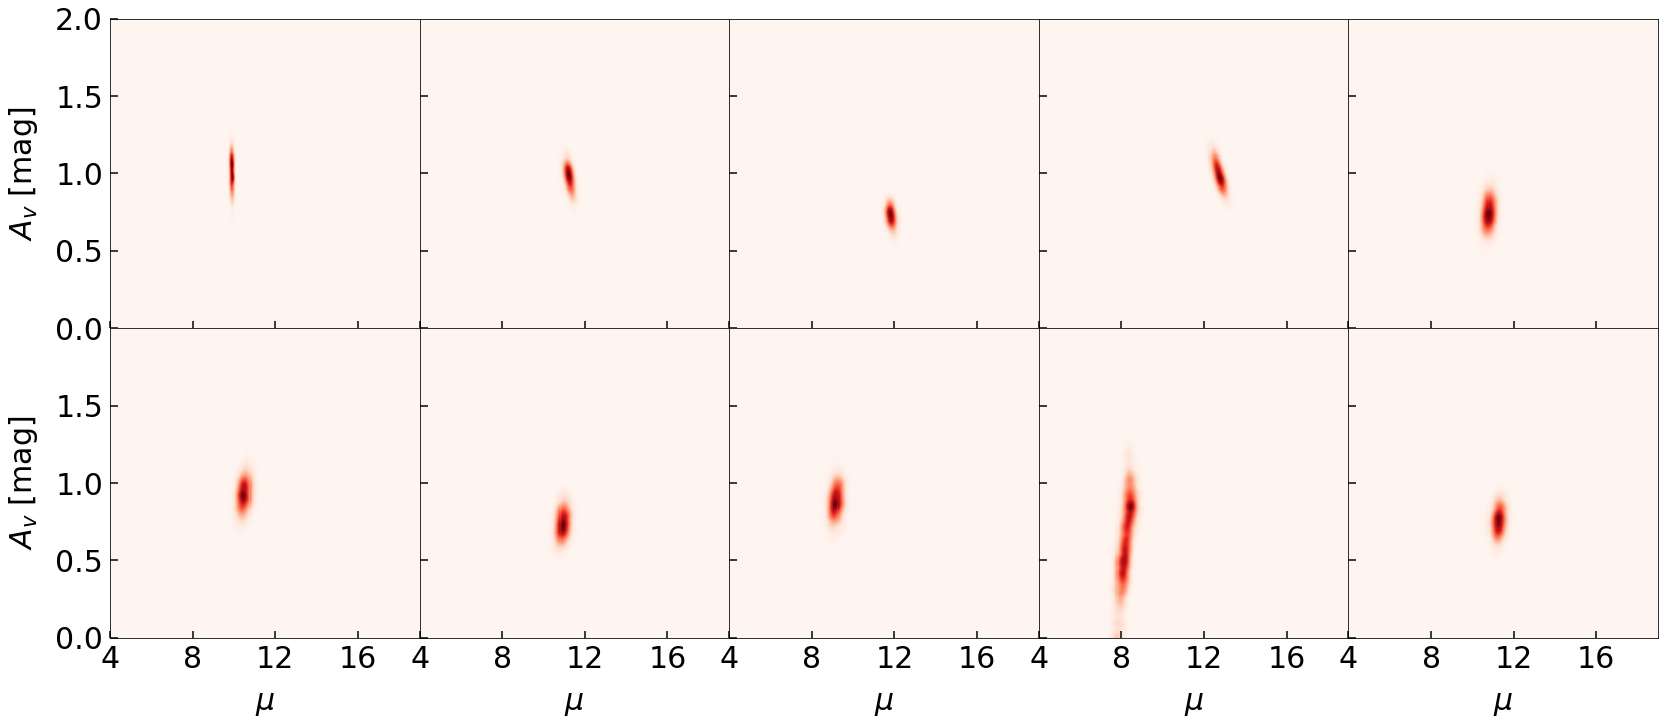

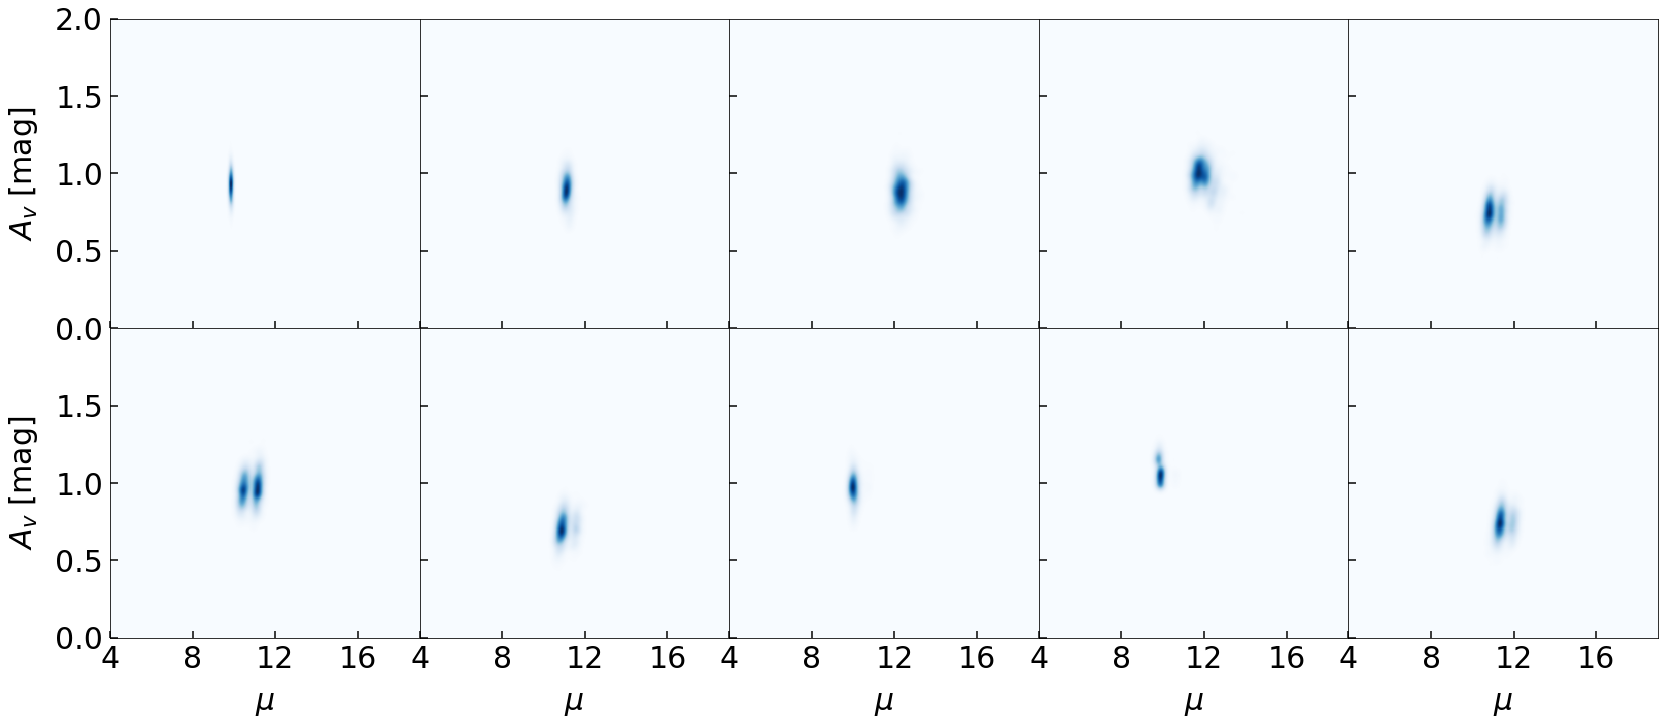

In [43]:
# distance-reddening 2-D posteriors
# Bayestar subset
xdim, ydim = 25, 10
fig = plt.figure(figsize=(xdim, ydim))
fig.subplots_adjust(bottom=0.12, top=0.98,
                    left=0.12, right=0.98,
                    wspace=0.00, hspace=0.00)
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red((dists_bs[i], reds_bs[i], dreds_bs[i]), 
                      parallax=parallax[i], 
                      parallax_err=parallax_err[i],
                      avlim=(0., 2.),
                      cmap='Reds')
    plt.tick_params(direction='in')
    if i % 5 == 0 and i >= xdim//5 * ydim//5 - 5:
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5))
    elif i % 5 == 0:
        plt.xlabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2.1, 0.5))
    elif i >= xdim//5 * ydim//5 - 5:
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5), [])
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5), [])

# MIST subset
fig = plt.figure(figsize=(xdim, ydim))
fig.subplots_adjust(bottom=0.12, top=0.98,
                    left=0.12, right=0.98,
                    wspace=0.00, hspace=0.00)
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red((dists_mist[i], reds_mist[i], dreds_mist[i]), 
                      parallax=parallax[i], 
                      parallax_err=parallax_err[i],
                      avlim=(0., 2.),
                      cmap='Blues')
    plt.tick_params(direction='in')
    if i % 5 == 0 and i >= xdim//5 * ydim//5 - 5:
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5))
    elif i % 5 == 0:
        plt.xlabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2.1, 0.5))
    elif i >= xdim//5 * ydim//5 - 5:
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5), [])
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5), [])

# Utilities

`brutus` contains a suite of utilities to help analyze results located under the `utils` module. A few examples are highlighted below.

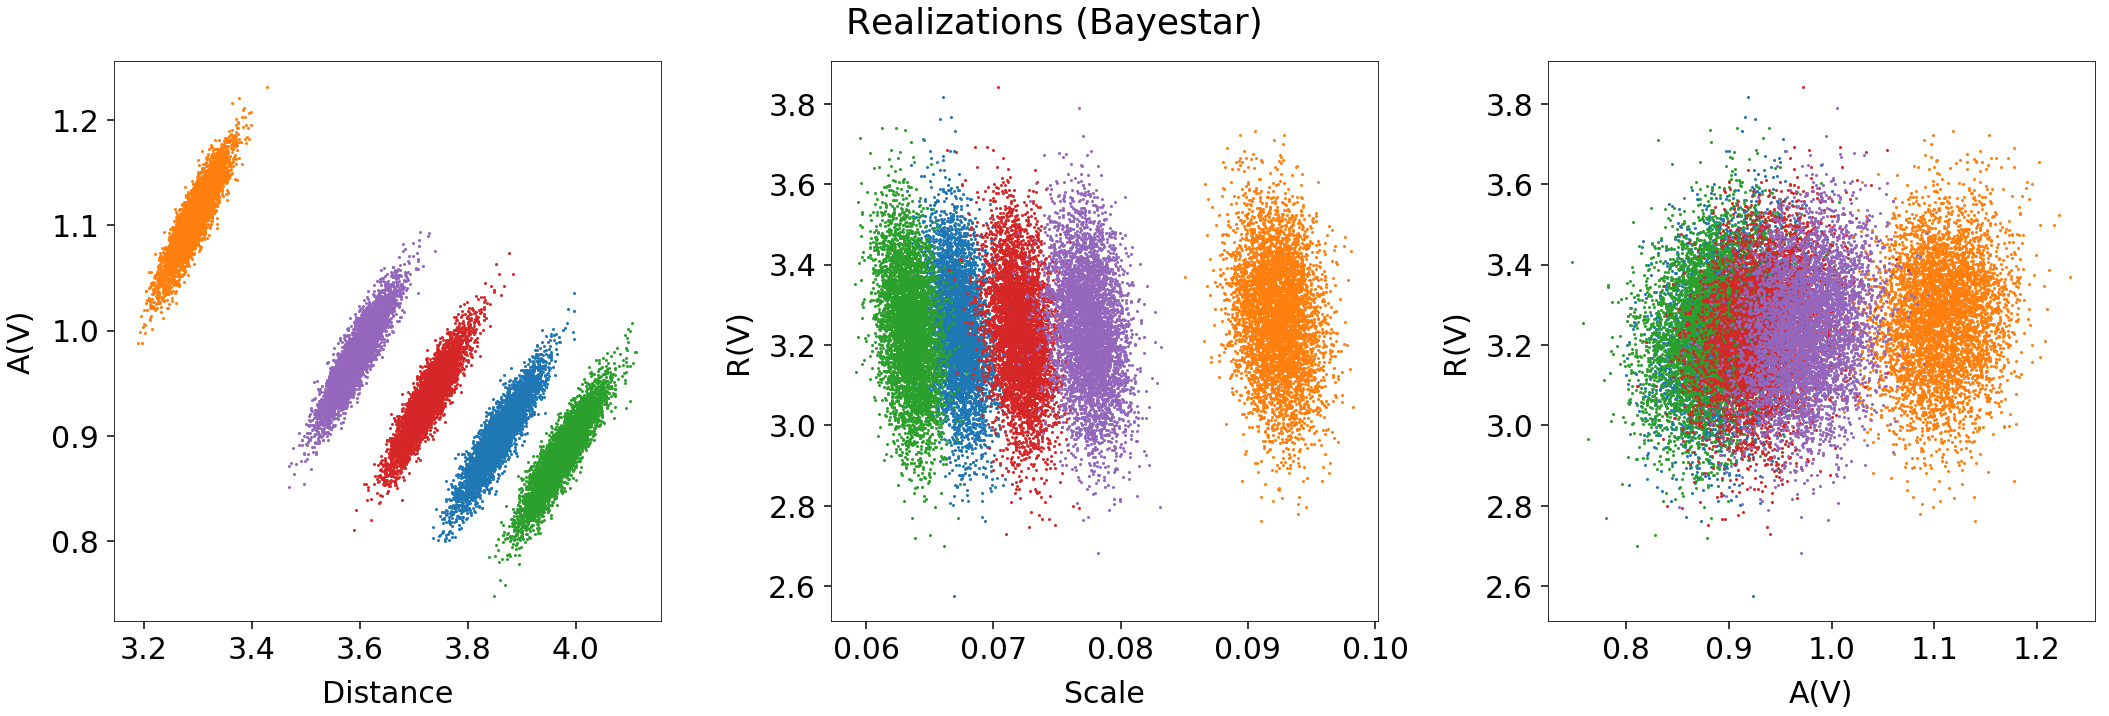

In [93]:
# load Bayestar results
f = h5py.File(filename+'_bs'+'.h5')
scales = f['scales'][:]  # ML scale-factor
avs = f['avs'][:]  # ML A(V)
rvs = f['rvs'][:]  # ML R(V)
covs_sar = f['cov_sar'][:]  # ML covariances

# draw reddening realizations (ignores non-Gaussian priors)
scales_r, avs_r, rvs_r = brutus.utils.draw_sar(scales[i], avs[i], rvs[i], 
                                               covs_sar[i], ndraws=5000)
dists_r = 1. / np.sqrt(scales_r)  # convert from scalefactor -> distance

# plot a few results
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
for j in range(5):
    plt.plot(dists_r[j], avs_r[j], 'o', ms=2)
plt.xlabel('Distance')
plt.ylabel('A(V)')
plt.subplot(1, 3, 2)
for j in range(5):
    plt.plot(scales_r[j], rvs_r[j], 'o', ms=2)
plt.xlabel('Scale')
plt.ylabel('R(V)')
plt.subplot(1, 3, 3)
for j in range(5):
    plt.plot(avs_r[j], rvs_r[j], 'o', ms=2)
plt.xlabel('A(V)')
plt.ylabel('R(V)')
plt.suptitle('Realizations (Bayestar)', y=1.02)
plt.tight_layout()

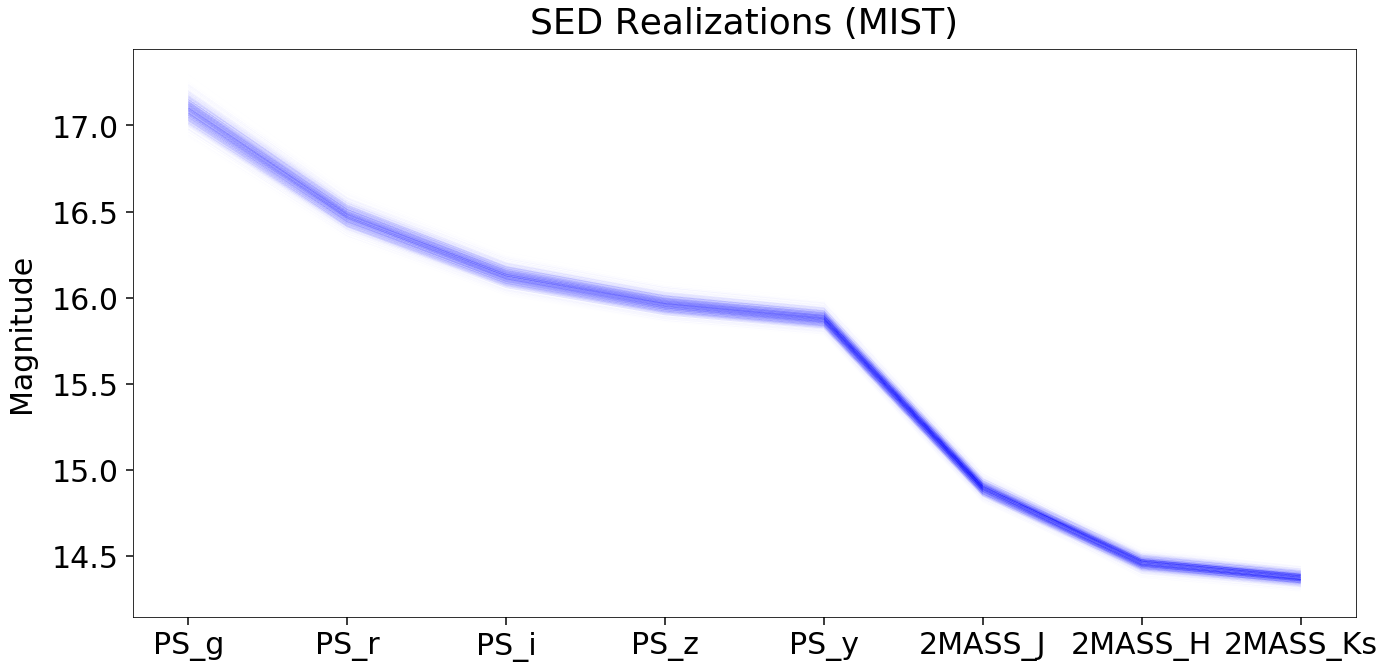

In [94]:
# generate SEDs
mags = brutus.utils.get_seds(models_mist[idxs_mist[i]], av=reds_mist[i], rv=dreds_mist[i])
mags += 5. * np.log10(dists_mist[i])[:, None]  # distance correction

# plot SEDs
plt.figure(figsize=(20, 10))
for j, m in enumerate(mags):
    plt.plot(m, color='blue', alpha=0.02, lw=0.2)
plt.xticks(np.arange(len(filt)), filt)
plt.ylabel('Magnitude')
plt.title('SED Realizations (MIST)')
plt.tight_layout()

# Deriving Line-of-Sight Dust Posteriors

`brutus` can also model the dust along the line of sight from many individual stellar posteriors using some of the functions contained in the `los` module. It is designed with a sampler like `dynesty` in mind, but is ultimately compatible with a range of possible samplers such as `emcee` with additional input from the user. An example is shown below.

In [90]:
from brutus import los
import dynesty

dms_bs = 5. * np.log10(dists_bs) + 10.  # convert to distance modulus

loglikelihood = los.LOS_clouds_loglike_samples  # log-likelihood (samples)
prior_transform = los.LOS_clouds_priortransform  # prior transform

nclouds = 1  # number of clouds
smooth = True  # add adaptive smoothing to the fit
ndim = 2 * nclouds + 2 * smooth + 2  # number of parameters

# fit dust along the LOS with dynesty
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                sample='rwalk', walks=25,
                                update_interval=5.,
                                ptform_kwargs={'dlims': (6., 10.),
                                               'smooth': smooth},
                                logl_args=[dms_bs, reds_bs])
sampler.run_nested(dlogz=0.01)

# grab results
results_bs = sampler.results

iter: 6947+500 | bound: 62 | nc: 1 | ncall: 145932 | eff(%):  5.103 | loglstar:   -inf <  6.661 <    inf | logz: -2.613 +/-  0.105 | dlogz:  0.000 >  0.010            

We can visualize our results using plotting utilities in `dynesty`. As we might expect, with only a handful of stars we don't really have a strong constraint on the dust along the line of sight.

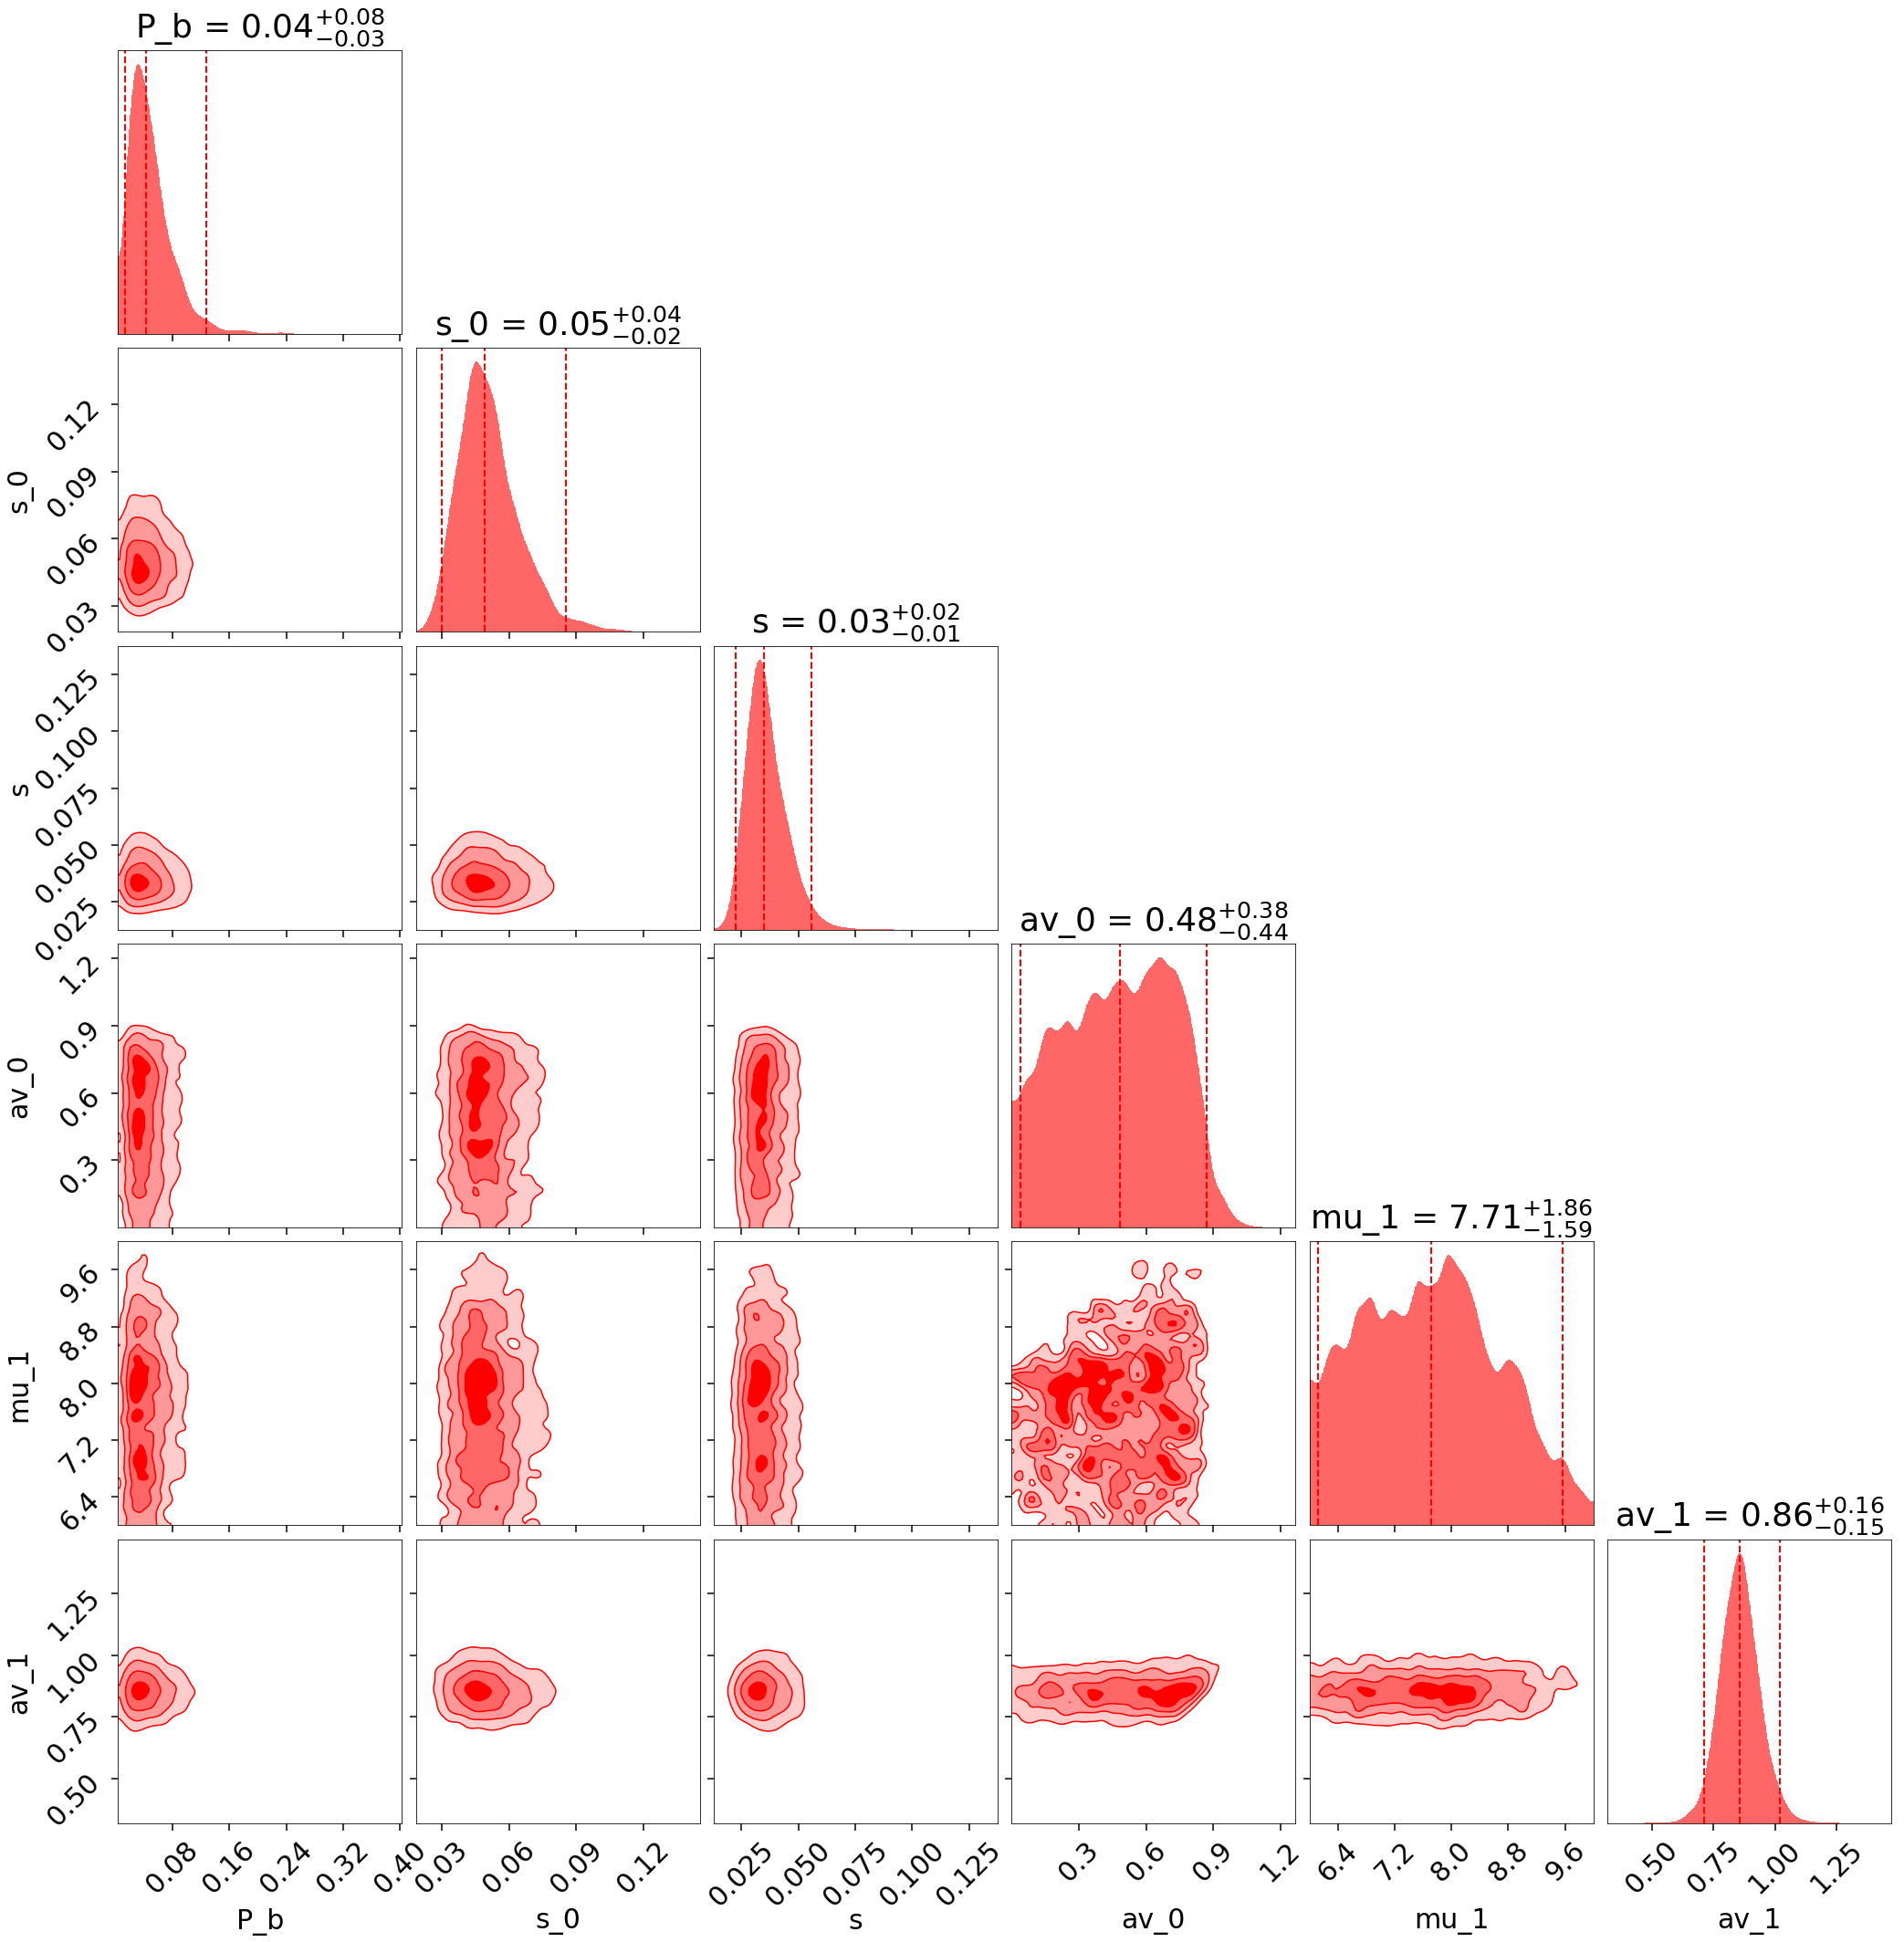

In [91]:
# plot results
from dynesty import plotting as dyplot

fig, ax = dyplot.cornerplot(results_bs, labels=['P_b', 's_0', 's', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True, color='red',
                            fig=plt.subplots(6, 6, figsize=(30, 30)))

Here's the comparison with MIST for good measure.

In [95]:
# fit dust along the LOS with dynesty
dms_mist = 5. * np.log10(dists_mist) + 10.  # convert to distance modulus
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                sample='rwalk', walks=25,
                                update_interval=5.,
                                ptform_kwargs={'dlims': (6., 10.),
                                               'smooth': smooth},
                                logl_args=[dms_mist, reds_mist])
sampler.run_nested(dlogz=0.01)

# grab results
results_mist = sampler.results

iter: 6899+500 | bound: 61 | nc: 1 | ncall: 145714 | eff(%):  5.078 | loglstar:   -inf <  7.268 <    inf | logz: -1.909 +/-  0.104 | dlogz:  0.000 >  0.010            

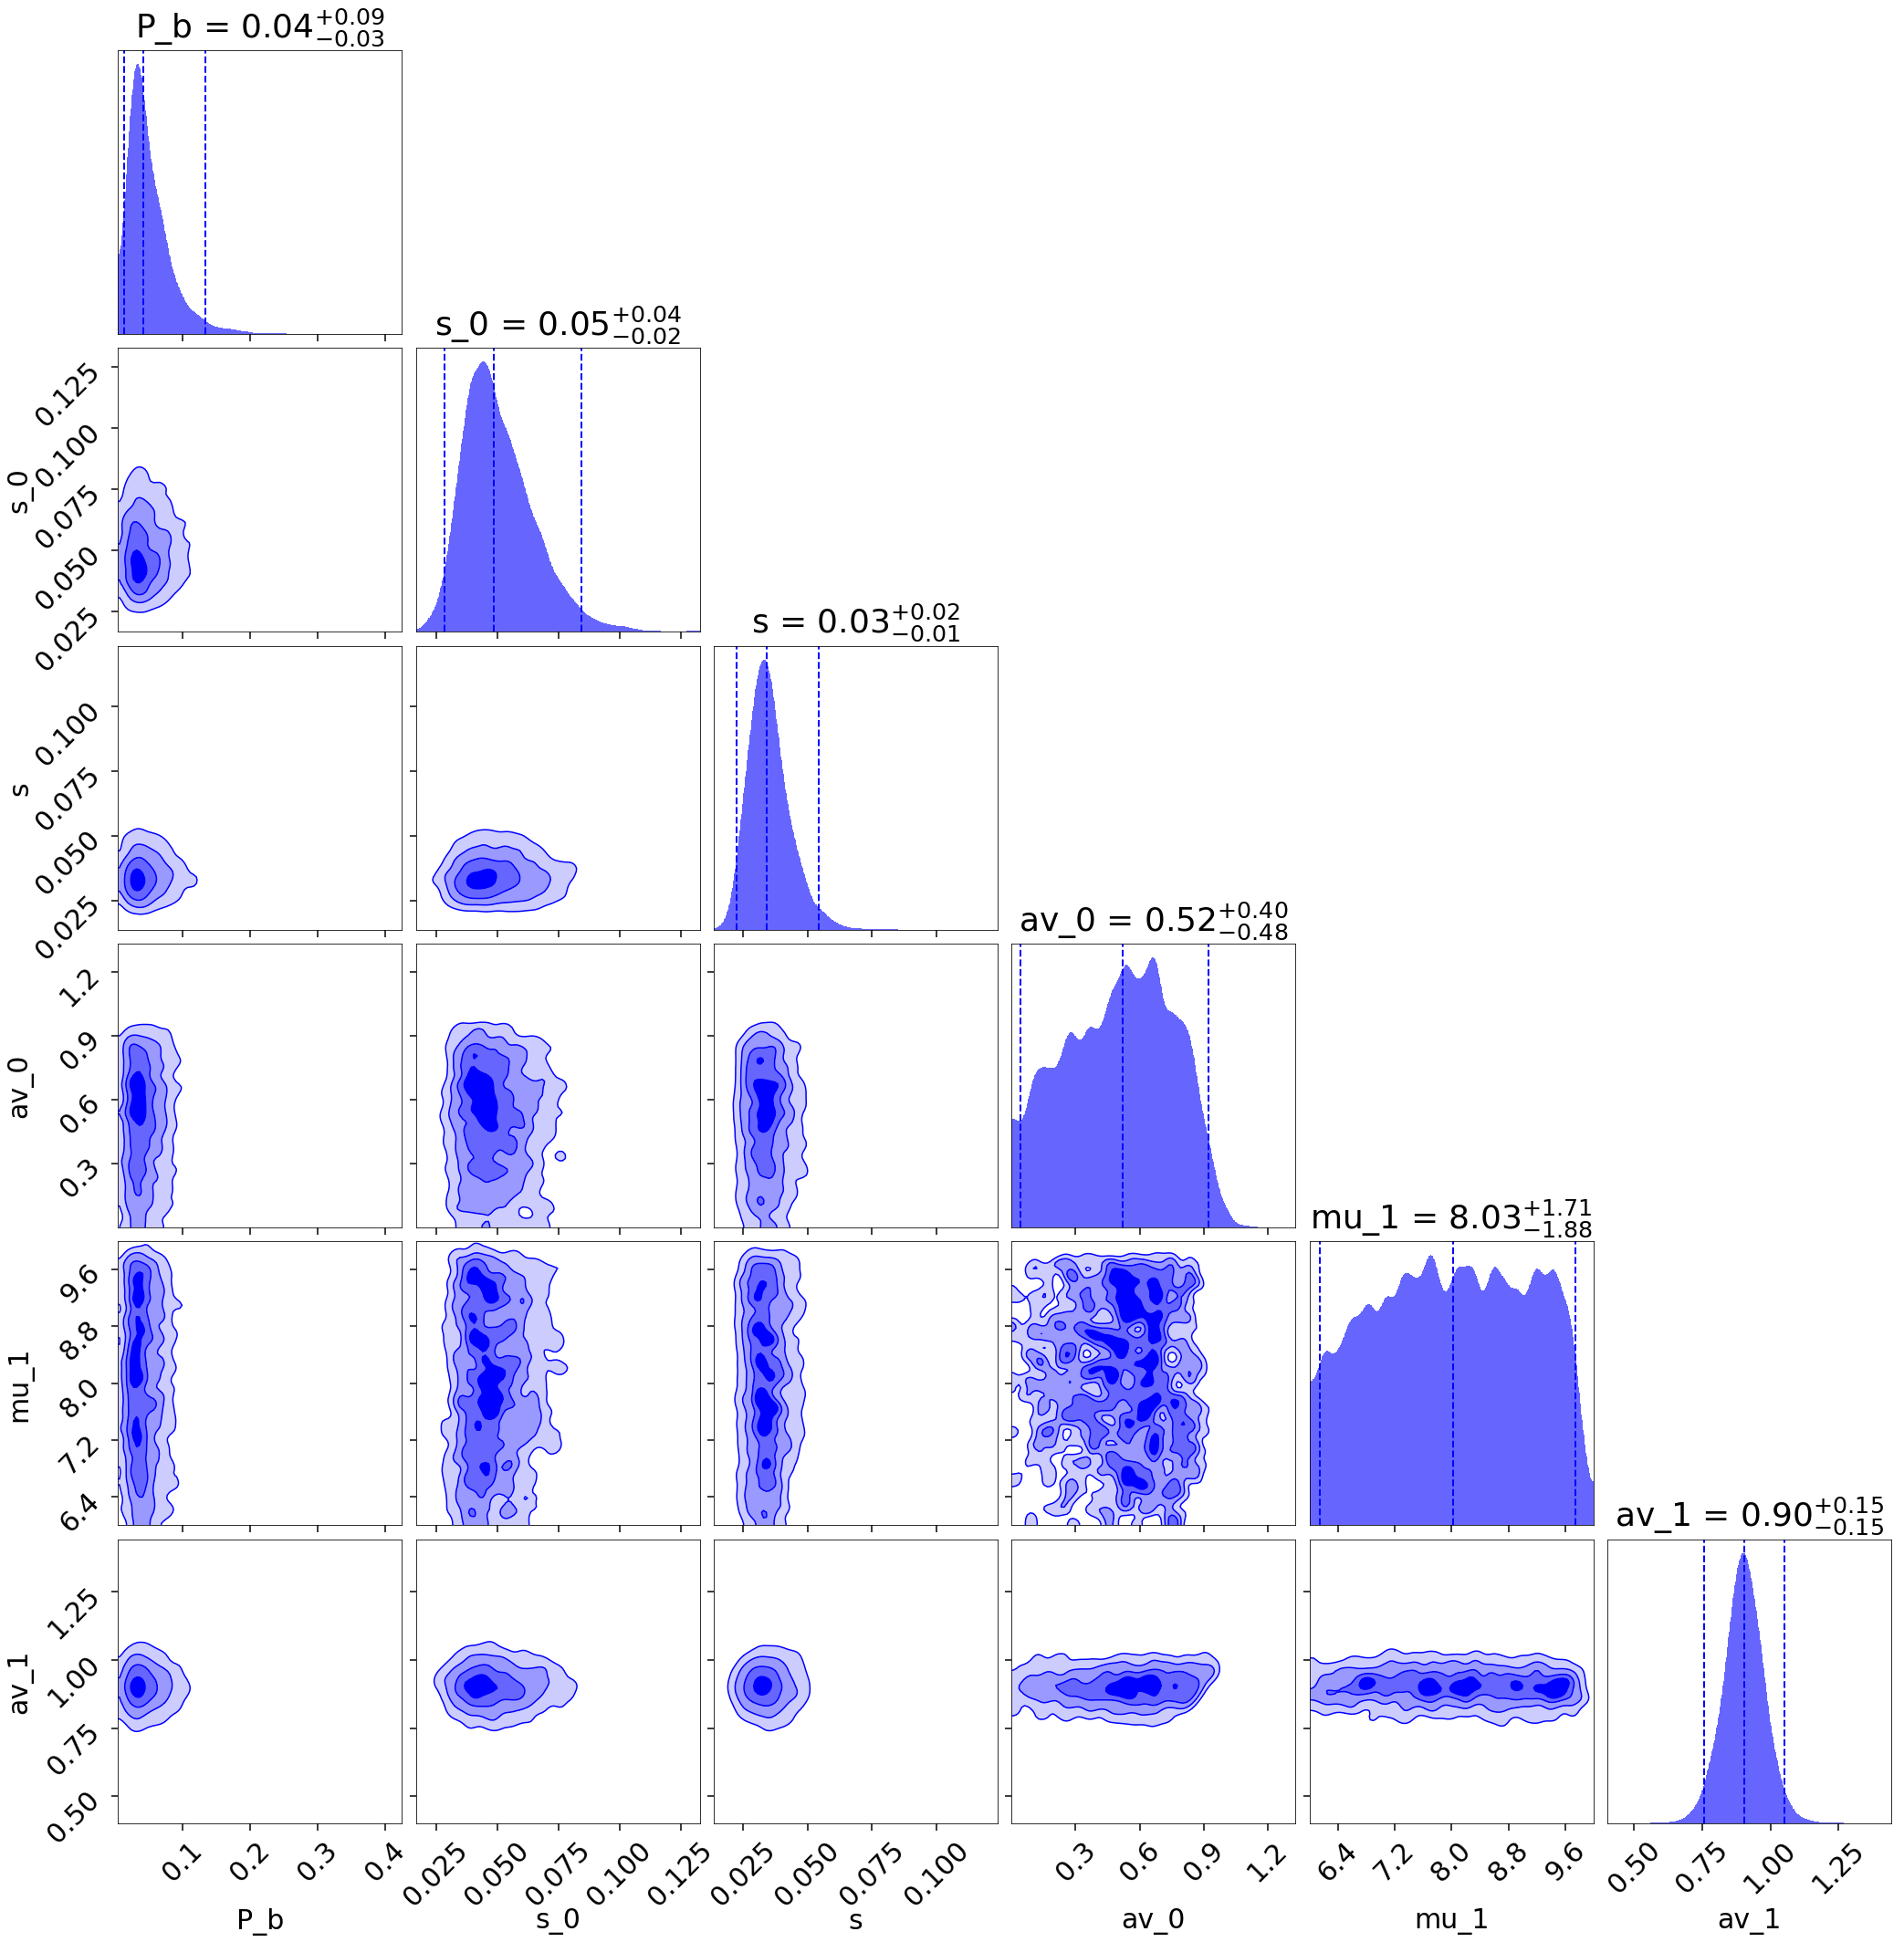

In [96]:
# plot results
fig, ax = dyplot.cornerplot(results_mist, labels=['P_b', 's_0', 's', 'av_0', 'mu_1', 'av_1'],
                            show_titles=True, color='blue',
                            fig=plt.subplots(6, 6, figsize=(30, 30)))